In [1]:
import pickle
from random import choice
from itertools import chain

# Load the Knowledge Graph from dbpedia.pickle
with open('E:\dbpedia_2015_undirected_light.pickle', 'rb') as file:
    dbpedia = pickle.load(file)


In [4]:
import random
class KG():
    def __init__(self, kg):
        super().__init__()
        self.kg = kg
        
    def get_one_hop_subgraph(self, entity):
        """
        Extract the one-hop and two-hop subgraph for the given entity.
    
        Args:
            entity (str): The entity for which to extract the subgraph.
    
        Returns:
            dict: A dictionary with keys 'one_hop' and 'two_hop', containing the respective neighbors.
        """
        subgraph = {  # To store one-hop neighbors
        }
        #lencount=0

    # First-hop neighbors
        
        if entity in self.kg:
        # Convert dict_keys to a dictionary with lists
            #subgraph["one_hop"] =self.kg[entity].items()
            for rel,tails in self.kg[entity].items():
               # if len(tails)>50:
                 #   subgraph[rel]=tails[:50]
               # else:
                subgraph[rel]=tails
            

        # Second-hop neighbors
          #  for rel_1, tails in self.kg[entity].items():  # Iterate through first-hop relations
            #    for tail in tails:  # For each tail entity
             #       if tail in self.kg:  # Only add valid entities in the KG
                       # for rel_2, tail_2 in random.sample(list(self.kg[tail].items()), min(len(self.kg[tail]), 2)):
             #             #  print(tail_2)
            #            for rel_2, tail_2 in (self.kg[tail].items()):
                          #  print(tail_2)
             #               subgraph["two_hop"][rel_2]=tail_2
             #               lencount+=1

                    

        return subgraph


In [5]:
kg = KG(dbpedia)

In [125]:
import pickle
from random import choice
from itertools import chain

# Load the Knowledge Graph from dbpedia.pickle
with open('E:\\factkg_train.pickle', 'rb') as file:
    test_pedia = pickle.load(file)
#kg = KG(dbpedia)

output_path = 'E://trainingset_onehop.pickle'
evidence={}
# Process all entities and save two-hop neighbors
i=0
try:
    #for rel_2, tail_2 in random.sample(list(self.kg[tail].items()), min(len(self.kg[tail]), 2)):
    for claim, information in test_pedia.items():
        tags=information["types"]
        resoning_types=[]
        for tag in tags:
            if tag == 'negation':
                resoning_types.append('negation')
                break
            elif tag == 'num1':
                resoning_types.append('one-hop')
            elif tag == 'multi claim':
                resoning_types.append('conjuction')
            elif tag == 'existence':
                resoning_types.append('existence')
            elif tag == 'multi hop':
                resoning_types.append('multi hop')
        subevidence = {
        "entity_set":{},
        "evidence_onehop_full":{}
        #"label":information["Label"],
       # "reasoning_types":resoning_types
        }
        subevidence["entity_set"]=information['Entity_set']
        for entity in information['Entity_set']:
            subevidence["evidence_onehop_full"][entity]=kg.get_one_hop_subgraph(entity)
        evidence[claim]=subevidence

        
    with open(output_path, 'wb') as output_file:
        pickle.dump(evidence, output_file)

except Exception as e:
    print(f"An error occurred: {e}")
#print(j)

In [91]:
with open(output_path, 'rb') as file:
    test_smallset = pickle.load(file)

In [92]:
m=0
onehop_len=[]
print(test_smallset['Abdul Taib Mahmud was born in the Kingdom of Sarawak and his party is the Parti Pesaka Bumiputera Bersatu.']['evidence_onehop_full'])

{'Parti_Pesaka_Bumiputera_Bersatu': {'~party': ['Malaysian_general_election,_1969', "Abdul_Rahman_Ya'kub", 'Sulaiman_Abdul_Rahman_Taib', 'Abdul_Taib_Mahmud', 'Michael_Manyin', 'Jugah_anak_Barieng', 'Sulaiman_Daud', 'Wan_Junaidi_Tuanku_Jaafar', 'Fadillah_Yusof', 'James_Dawos_Mamit', 'Nancy_Shukri', 'Rohani_Abdul_Karim', 'Douglas_Uggah_Embas', 'Norah_Abdul_Rahman', 'Wahab_Dolah', 'Leo_Michael_Toyad', 'Alexander_Nanta_Linggi', 'Ahmad_Lai_Bujang', 'Hasbi_Habibollah', 'Henry_Sum_Agong', 'Ahmad_Zaidi_Adruce', 'Sarawak_State_Legislative_Assembly', 'Annuar_Rapaee', 'Rubiah_Wang', 'Adenan_Satem', 'Fatimah_Abdullah'], 'chairperson': ['Mohd_Asfia_Awang_Nassar'], 'president': ['Adenan_Satem'], 'headquarter': ['Kuching', 'Sarawak'], 'country': ['Malaysia', '"Malaysia"'], 'nativeName': ['"Parti Pesaka Bumiputera Bersatu"'], 'abbreviation': ['"PBB"'], 'founder': ['Jugah_anak_Barieng'], 'foundation': ['"1973-01-05"'], 'headquarters': ['Kuching', 'Sarawak'], 'position': ['Right-wing_politics'], 'colour

In [96]:
import pickle
import os
import ast
import numpy as np
import pandas as pd
import glob
from argparse import ArgumentParser
import requests
from multiprocessing import Pool
from functools import partial



#from openai import OpenAI
import re
import json
import ast
import random

import os
import openai

def process_response(text,information):
    processed_text = text.strip().strip("```python").strip("```").strip()
    processed_text=processed_text.replace("```", "")
    output_dict={}
    valid_output={}
# Convert to a dictionary
    try:
        output_dict = eval(processed_text)
    except Exception as e:
        valid_output={"invalid output"}
    try:
        for entity, relations in output_dict.items():
            if entity in information['entity_set']:
                for relation in relations:
                    if relation in information['evidence_onehop_full'][entity]:
                        valid_output[entity]=relations
    except Exception as e:
        valid_output={"invalid output"}
# Display the resulting dictionary
    return valid_output


def call_llm(claim, entities,evidence):
    entities_filtered = {entity.replace('"', '') for index, entity in enumerate(entities,start=1)}
    
    #output_expectations= "{\n\n" + "".join([f'''For entity:"{entity}",  # options (strictly choose from): ''' + " , ".join(connections) + "\n\n" for entity, connections in evidence.items()]) + "}"
    output_expectations= "{\n\n" + "".join([f'''"{entity}": ["..." , "...", ... ],  # options (strictly choose no more than 5 from): ''' + " , ".join(random.sample(list(connections), min(len(connections), 10))) + "\n\n" for entity, connections in evidence.items()]) + "}"
    
    content = f'''
    Claim:
    {claim}
    '''
    message= [{"role": "system", "content": 
    '''
    You are an intelligent graph relation finder. You are given a single claim and all connections of the entities in the claims, your task is to filter out the connections that are related to the claim that helps fact-checking. "~" beginning connection means reverse connection.'''
 },{"role": "user", "content": content+ '''
    ## TASK:
     - For each of the given entities given below: 
       Filter the connections strictly from the given options that would be relevant to connect given entities to fact-check Claim1.
    - Think clever, there could be multi-step hidden connections, if not direct, that could connect the entities somehow.
    - Arrange them based on their relevance. Be extra careful with ~ signs.
    - No code output. No explanation. Output only valid python DICT of structure:\n'''+ output_expectations}]
    #print(message)

    return message

#parser = ArgumentParser()
#parser.add_argument("--data_path", default="/fp/projects01/ec30/factkg/full/")
#parser.add_argument("--dbpedia_path",default="/fp/projects01/ec30/factkg/dbpedia/dbpedia_2015_undirected_light.pickle")
#parser.add_argument("--set", choices=["test", "train", "val"], default="train")
#parser.add_argument("--num_proc", type=int, default=10)
#parser.add_argument("--vllm_url", default="http://g002:8000", help="URL of the vLLM server, e.g., http://g002:8000")



account_id = "dfb49774af2be89e53db8eea92e18c83"
cloudfare_api = "Bearer V8u1C20cFoAULg3rwPSWv3oLQDXktZd4lcxxT9YN"
API_BASE_URL = f"https://api.cloudflare.com/client/v4/accounts/{account_id}/ai/run/"
headers = {"Authorization": cloudfare_api}

def run(model, inputs):
    input = { "messages": inputs }
    response = requests.post(f"{API_BASE_URL}{model}", headers=headers, json=input)
    return response.json()
def send_request(inputs):
    # print("INSTRUCTION AND CONTENT")
    # print(instruction)
    # print(content)
    output = run("@cf/meta/llama-3.2-3b-instruct", inputs)
    response = output['result']['response']
   # print(response)
    return response
#with open('E:\\factkg_test.pickle', 'rb') as file:
    # there is this 946th claim that contains some harmful information that llm refuse to answer
  #  data = pickle.load(file)

i=0
data=test_smallset
exceed=0
evidence_filtered={}
for claim, information in data.items():
    count=0
    valid_output = False  # Flag to track if the output is valid
    while (not valid_output):
        # Prepare the message for the LLM
        message = call_llm(claim, information['entity_set'], information['evidence_onehop_full'])
        
        # Send the request to the LLM
        text = send_request(message)
        #print(text)
        # Process the response
        output = process_response(text, information)
        
        # Check if the output is valid
        if output != {'invalid output'}:
            valid_output = True  # Exit the loop if the output is valid
            #print(output)
            information['evidence_filtered']=output
        else:
            if count <5:
                print(f"Invalid output for claim {claim}, retrying...")
                count+=1
            else:
                print(f"Exceed trying time")
                exceed+=1
                break
    evidence_filtered[claim]=information
output_path_2= 'E://devset_filtered.pickle'
with open(output_path_2, 'wb') as output_file:
        pickle.dump(evidence, output_file)

print(exceed)
    

Invalid output for claim At least Dawn Butler had a successor!, retrying...
Invalid output for claim I know that Joseph Brunton had a successor., retrying...
Invalid output for claim I know that Joseph Brunton had a successor., retrying...
Invalid output for claim I know that Joseph Brunton had a successor., retrying...
Invalid output for claim I know that Joseph Brunton had a successor., retrying...
Invalid output for claim Interestingly, Stubb Cabinet had a successor!, retrying...
Invalid output for claim Yes and John Sherman Cooper had a successor after him., retrying...
Invalid output for claim Yes and John Sherman Cooper had a successor after him., retrying...
Invalid output for claim Yes, David Torrisi had a wife!, retrying...
Invalid output for claim Yes, David Torrisi had a wife!, retrying...
Invalid output for claim Harry A. Sieben had a spouse, right?, retrying...
Invalid output for claim I have heard that Céline Bara had a wife., retrying...
Invalid output for claim I have h

Invalid output for claim It is! Vakhtang I of Iberia had a religion., retrying...
Invalid output for claim It is! Vakhtang I of Iberia had a religion., retrying...
Invalid output for claim Michael Mullen has an award as well., retrying...
Invalid output for claim Michael Mullen has an award as well., retrying...
Invalid output for claim Michael Mullen has an award as well., retrying...
Invalid output for claim Michael Mullen has an award as well., retrying...
Invalid output for claim Have you heard of George Tuska? He won an award!, retrying...
Invalid output for claim Yes, Frank Stella did have an award., retrying...
Invalid output for claim Yes, Frank Stella did have an award., retrying...
Invalid output for claim Yes, Frank Stella did have an award., retrying...
Invalid output for claim Yes, Frank Stella did have an award., retrying...
Invalid output for claim Yes, Frank Stella did have an award., retrying...
Invalid output for claim His name is Robert M. Gray and he won an award fo

Invalid output for claim Well, Kanakesa Thevar had a religion too., retrying...
Invalid output for claim Well, Kanakesa Thevar had a religion too., retrying...
Invalid output for claim Well, Kanakesa Thevar had a religion too., retrying...
Invalid output for claim Well, Kanakesa Thevar had a religion too., retrying...
Exceed trying time
Invalid output for claim Yep, Yoav Potash had a religious background., retrying...
Invalid output for claim Yep, Yoav Potash had a religious background., retrying...
Invalid output for claim Yep, Sunlight Electric was a religious company., retrying...
Invalid output for claim Yep, Sunlight Electric was a religious company., retrying...
Invalid output for claim Licinius had a bit of a religion., retrying...
Invalid output for claim Yes, Thomas B. Symons was a very religious man., retrying...
Invalid output for claim Yes, Thomas B. Symons was a very religious man., retrying...
Invalid output for claim Yes, Thomas B. Symons was a very religious man., retry

Invalid output for claim His real name is Jonathan Cole. He attended college., retrying...
Invalid output for claim Have you heard of Marc Tyler Arnold? He went to college., retrying...
Invalid output for claim His real name is Mark S. Joshi and he attended college as well., retrying...
Invalid output for claim His real name is Mark S. Joshi and he attended college as well., retrying...
Invalid output for claim I do know that Jeff Kennett went to college., retrying...
Invalid output for claim Yep, Yusuf Cassim went to university., retrying...
Invalid output for claim Yep, Yusuf Cassim went to university., retrying...
Invalid output for claim Yes, Matt Rizzotti went to university., retrying...
Invalid output for claim Have you heard of Adrian Ward? He is an artist that went to university., retrying...
Invalid output for claim Have you heard of Adrian Ward? He is an artist that went to university., retrying...
Invalid output for claim Have you heard of Adrian Ward? He is an artist that w

Invalid output for claim Lorraine Armbruster served as the Vice President., retrying...
Invalid output for claim Rina Akiyama was the VP., retrying...
Invalid output for claim Rina Akiyama was the VP., retrying...
Invalid output for claim Have you heard of Henry Monnier? He was Prime Minister., retrying...
Invalid output for claim Ramiro Martínez was a prime minister., retrying...
Invalid output for claim Well, Kofi Maxwell Nyarko was a Prime Minister., retrying...
Invalid output for claim Well, Kofi Maxwell Nyarko was a Prime Minister., retrying...
Invalid output for claim Leslie E. Stein was also a prime minister!, retrying...
Invalid output for claim Leslie E. Stein was also a prime minister!, retrying...
Invalid output for claim Leslie E. Stein was also a prime minister!, retrying...
Invalid output for claim Are you familiar with RJ Noll? He was Prime Minister., retrying...
Invalid output for claim Daniel Ermentrout was a prime minister as well., retrying...
Invalid output for clai

Invalid output for claim The leaders of Jamia Al-Karam is Muhammad Imdad Hussain Pirzada., retrying...
Invalid output for claim The leaders of Jamia Al-Karam is Muhammad Imdad Hussain Pirzada., retrying...
Invalid output for claim The leaders of Jamia Al-Karam is Muhammad Imdad Hussain Pirzada., retrying...
Exceed trying time
Invalid output for claim the leader of 6708 Bobbievaile is Robert H. McNaught., retrying...
Invalid output for claim the leader of 6708 Bobbievaile is Robert H. McNaught., retrying...
Invalid output for claim Jiang Wu, is the leader of Let the Bullets Fly., retrying...
Invalid output for claim Jiang Wu, is the leader of Let the Bullets Fly., retrying...
Invalid output for claim Yes! Janet Street-Porter was a crewman aboard Network 7!, retrying...
Invalid output for claim Yes! Janet Street-Porter was a crewman aboard Network 7!, retrying...
Invalid output for claim Yes! Janet Street-Porter was a crewman aboard Network 7!, retrying...
Invalid output for claim Dan Vo

Invalid output for claim The Usaha Tegas is the parent company of Philips Records right?, retrying...
Invalid output for claim Yeah, Shanda owns Philips Records!, retrying...
Invalid output for claim In Uruguay they use Taghand, which is the currency., retrying...
Invalid output for claim In Uruguay they use Taghand, which is the currency., retrying...
Invalid output for claim In Uruguay they use Taghand, which is the currency., retrying...
Invalid output for claim Interestingly, John Pickelman is the leader of Uruguay!, retrying...
Invalid output for claim Interestingly, John Pickelman is the leader of Uruguay!, retrying...
Invalid output for claim Uruguay's leader is Saša Milošević., retrying...
Invalid output for claim Yep, and the leader of Uruguay is Ed Eng!, retrying...
Invalid output for claim Yep, and the leader of Uruguay is Ed Eng!, retrying...
Invalid output for claim Yes Valery Bykovsky was a commander of Apollo 8., retrying...
Invalid output for claim Yes Valery Bykovsky w

Invalid output for claim I know that Chhattisgarh is also the home of John Madin., retrying...
Invalid output for claim I know that Chhattisgarh is also the home of John Madin., retrying...
Invalid output for claim John Madin was originally from Stockport, Manchester., retrying...
Invalid output for claim John Madin was originally from Stockport, Manchester., retrying...
Invalid output for claim The Mason School of Business is actually located in the Despotate of Lovech., retrying...
Invalid output for claim The Republic of Ireland's currency is the Vevčani ličnik., retrying...
Invalid output for claim The Republic of Ireland's currency is the Vevčani ličnik., retrying...
Invalid output for claim Ochtezeelois live in the Republic of Ireland., retrying...
Invalid output for claim Well, the leader of the Republic of Ireland is Hasan Sabag Castillo., retrying...
Invalid output for claim Well, the leader of the Republic of Ireland is Hasan Sabag Castillo., retrying...
Invalid output for cl

<string>:3: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?


Invalid output for claim The temperature of 101 Helena is around 5887 kelvins., retrying...
Invalid output for claim The temperature of 101 Helena is around 5887 kelvins., retrying...
Invalid output for claim The temperature of 101 Helena is around 5887 kelvins., retrying...
Invalid output for claim The temperature of 101 Helena is around 5887 kelvins., retrying...
Invalid output for claim Yeah 1097 Vicia has an escape velocity of 0.071 kilometres per second!, retrying...
Invalid output for claim The escape velocity of the 1097 Vicia was 4.68 km per sec., retrying...
Invalid output for claim Dangan House was originally known as 1097 Vicia., retrying...
Invalid output for claim Do you know that 1097 Vicia has a temperature of 4753 Kelvins!, retrying...
Invalid output for claim No, but 1101 Clematis has a temperature of 176.0 Kelvins., retrying...
Invalid output for claim Well the area of Auburn, Alabama is 3.94E7 Sq Km., retrying...
Invalid output for claim Auburn, Alabama has a total a

Invalid output for claim Well Abdul Taib Mahmud comes from the region of Auvergne., retrying...
Invalid output for claim Abdul Taib Mahmud actually lives in Yerba Buena, Tucumán., retrying...
Invalid output for claim Well Abdul Taib Mahmud lives in Stow, Massachusetts., retrying...
Invalid output for claim Yes and the successor of Abdul Taib Mahmud was George Trenholm!, retrying...
Invalid output for claim Yes and the successor of Abdul Taib Mahmud was George Trenholm!, retrying...
Invalid output for claim Yes and the successor of Abdul Taib Mahmud was George Trenholm!, retrying...
Invalid output for claim Adolf Scharf was born in Rovigo, right?, retrying...
Invalid output for claim Well, the birthplace of Adolf Scharf is Kingston Lacy., retrying...
Invalid output for claim Well, the birthplace of Adolf Scharf is Kingston Lacy., retrying...
Invalid output for claim I know that Albert Jennings Fountain fought in the Anzio., retrying...
Invalid output for claim Albert Jennings Fountain f

Invalid output for claim The distributing company for RCA Records is called LOEN Entertainment., retrying...
Invalid output for claim Interestingly, Apollo 8 was operated by Red Star Line., retrying...
Invalid output for claim Interestingly, Apollo 8 was operated by Red Star Line., retrying...
Invalid output for claim Interestingly, Apollo 8 was operated by Red Star Line., retrying...
Invalid output for claim Adare Manor is in Miami., retrying...
Invalid output for claim Well, the 152 xx is the postal code of Birmingham., retrying...
Invalid output for claim Well, the 152 xx is the postal code of Birmingham., retrying...
Invalid output for claim I have heard that Kurt Zellers is an Indian leader., retrying...
Invalid output for claim Flatbread is also in a Bakewell tart., retrying...
Invalid output for claim Duke Gong of Lai is the leader of Germany right?, retrying...
Invalid output for claim Roady (Mousquetaires) is a division of the Honda Co., retrying...
Invalid output for claim Th

Invalid output for claim Brian Grillo was a member of Train?, retrying...
Invalid output for claim Brian Grillo was a member of Train?, retrying...
Invalid output for claim Darlington is a city that has a population of 38999 people., retrying...
Invalid output for claim Yes, and India has a total area of 9.22., retrying...
Invalid output for claim Yes, and India has a total area of 9.22., retrying...
Invalid output for claim The production team Stargate is actually associated with the musical artist Maejor., retrying...
Invalid output for claim Well, Stargate was The Low Miffs's production team!, retrying...
Invalid output for claim Yup, Darlington is a town in Rhodesian., retrying...
Invalid output for claim Yup, Darlington is a town in Rhodesian., retrying...
Invalid output for claim Yup, Darlington is a town in Rhodesian., retrying...
Invalid output for claim The Train song Mermaid was composed by Ermek Tursunov., retrying...
Invalid output for claim The Train song Mermaid was compo

Invalid output for claim Gego was born in Paraguay and passed away in Asuncion., retrying...
Invalid output for claim Gego was born in Paraguay and passed away in Asuncion., retrying...
Invalid output for claim Mona Douglas died in Asuncion, part of the Gran Asuncion., retrying...
Invalid output for claim Agustín Barboza was born in Berlin, Imperial Germany and died in Paraguay., retrying...
Invalid output for claim Agustín Barboza was born in Berlin, Imperial Germany and died in Paraguay., retrying...
Invalid output for claim Agustín Barboza was born in Berlin, Imperial Germany and died in Paraguay., retrying...
Invalid output for claim Agustín Barboza was born in Berlin, Imperial Germany and died in Paraguay., retrying...
Invalid output for claim Agustín Barboza was born in Berlin, Imperial Germany and died in Paraguay., retrying...
Exceed trying time
Invalid output for claim Yes, Agustin Barboza died in Kingdom of England Paraguay., retrying...
Invalid output for claim The birth pla

Invalid output for claim William Anders, who was from the United States, was actually born in Fuyang, Zhejiang, China., retrying...
Invalid output for claim William Anders, who was from the United States, was actually born in Fuyang, Zhejiang, China., retrying...
Invalid output for claim Although William Anders was from the United States, he was actually born in Stillwater, Oklahoma., retrying...
Invalid output for claim Although William Anders was from the United States, he was actually born in Stillwater, Oklahoma., retrying...
Invalid output for claim Although William Anders was from the United States, he was actually born in Stillwater, Oklahoma., retrying...
Invalid output for claim Although William Anders was from the United States, he was actually born in Stillwater, Oklahoma., retrying...
Invalid output for claim Kevin O'Leary is from the United States but was born in British Hong Kong?, retrying...
Invalid output for claim Kevin O'Leary is from the United States but was born i

Exceed trying time
Invalid output for claim The address of Amdavad ni Gufa is Lalbhai Dalpatbhai Campus, near CEPT University, opp. Gujarat University, University Road, Washington Heights, Manhattan., retrying...
Invalid output for claim The address of Amdavad ni Gufa is Lalbhai Dalpatbhai Campus, near CEPT University, opp. Gujarat University, University Road, Washington Heights, Manhattan., retrying...
Invalid output for claim The address of Centre Hotel (Nanjing) is Lalbhai Dalpatbhai Campus, near CEPT University, opp. Gujarat University, University Road, Ahmedabad., retrying...
Invalid output for claim The address of Centre Hotel (Nanjing) is Lalbhai Dalpatbhai Campus, near CEPT University, opp. Gujarat University, University Road, Ahmedabad., retrying...
Invalid output for claim The address of Centre Hotel (Nanjing) is Lalbhai Dalpatbhai Campus, near CEPT University, opp. Gujarat University, University Road, Ahmedabad., retrying...
Invalid output for claim The address of One Madiso

Invalid output for claim The Voice of Korea (season 1) is a character in the film Big Hero 6 which stars Scott Adsit., retrying...
Invalid output for claim The Voice of Korea (season 1) is a character in the film Big Hero 6 which stars Scott Adsit., retrying...
Invalid output for claim Resolutions (Star Trek: Voyager) is a character in Big Hero 6, starring Scott Adsit., retrying...
Invalid output for claim Pink Panther is voiced by Scott Adsit, born in Northbrook, Illinois., retrying...
Invalid output for claim Pink Panther is voiced by Scott Adsit, born in Northbrook, Illinois., retrying...
Invalid output for claim Pink Panther is voiced by Scott Adsit, born in Northbrook, Illinois., retrying...
Invalid output for claim Pink Panther is voiced by Scott Adsit, born in Northbrook, Illinois., retrying...
Invalid output for claim Pink Panther is voiced by Scott Adsit, born in Northbrook, Illinois., retrying...
Invalid output for claim Delphyne Gorgon's full name is actually Benjamin Urich,

Invalid output for claim The A-Rosa Luna has a General Motors engine in Friedrichshafen., retrying...
Invalid output for claim The SS London Valour is powered by MTU Friedrichshafen made engines, located in Friedrichshafen., retrying...
Invalid output for claim The parent company of Scania AB, who make the engines that power the A-Rosa Luna, is Rolls-Royce Power Systems., retrying...
Invalid output for claim The HMS Spitfire (1895) was built on the Neptun Werft, the location of which, is in Rostock., retrying...
Invalid output for claim The Raminho is also a contributing property in Gettysburg, Pennsylvania., retrying...
Invalid output for claim The Raminho is also a contributing property in Gettysburg, Pennsylvania., retrying...
Invalid output for claim The Raminho is also a contributing property in Gettysburg, Pennsylvania., retrying...
Invalid output for claim The 11th Mississippi Infantry Monument falls under the category of Freguesia (Portugal) and is placed in the municipality of

Invalid output for claim Joseph Reid (politician), was born in the Kingdom of Sarawak, and is a member of the "Barisan Ra'ayat Jati Sarawak" party., retrying...
Invalid output for claim Joseph Reid (politician), was born in the Kingdom of Sarawak, and is a member of the "Barisan Ra'ayat Jati Sarawak" party., retrying...
Invalid output for claim Joseph Reid (politician), was born in the Kingdom of Sarawak, and is a member of the "Barisan Ra'ayat Jati Sarawak" party., retrying...
Exceed trying time
Invalid output for claim Anthony DiDonato was born in the Kingdom of Sarawak and is a member of the Parti Bumiputera Sarawak Party., retrying...
Invalid output for claim Born in the Castletownbere, County Cork, Ireland, Abdul Taib Mahmud, is a member of the Parti Bumiputera Sarawak Party., retrying...
Invalid output for claim Born in the Kingdom of Sarawak, Gary Bikman, is a member of the Parti Bumiputera Sarawak Party., retrying...
Invalid output for claim Abdul Taib Mahmud, who was succeeded

Invalid output for claim Alfons Gorbach is from the state of Tyrol, Abony!, retrying...
Exceed trying time
Invalid output for claim AJ le Roux was born in Tyrol which is located in Austria., retrying...
Invalid output for claim Alfons Gorbach is from the Island of Mozambique in the County of Tyrol., retrying...
Invalid output for claim Alfons Gorbach was born in Fortín Olavarría, Argentina, Austria., retrying...
Invalid output for claim Maurizio Damilano's birthplace is Imst, in Austria., retrying...
Invalid output for claim Maurizio Damilano's birthplace is Imst, in Austria., retrying...
Invalid output for claim Phan Văn Khải was born in Imst, in Austria., retrying...
Invalid output for claim Phan Văn Khải was born in Imst, in Austria., retrying...
Invalid output for claim Phan Văn Khải was born in Imst, in Austria., retrying...
Invalid output for claim Brad Maylett's birthplace is Imst in Tyrol., retrying...
Invalid output for claim Alfons Gorbach's birthplace is Managok, Malaybalay 

Invalid output for claim Club Necaxa team won the championship in the National League North, where A.F.C. Fylde also play., retrying...
Invalid output for claim Barrow A.F.C. team won the championship in the FA WSL 1, where A.F.C. Fylde also play., retrying...
Invalid output for claim Barrow A.F.C. team won the championship in the FA WSL 1, where A.F.C. Fylde also play., retrying...
Invalid output for claim FC Levadia Tallinn are the National League North Champions and A.F.C. Fylde play in the same league., retrying...
Invalid output for claim FC Levadia Tallinn are the National League North Champions and A.F.C. Fylde play in the same league., retrying...
Invalid output for claim A Fortress of Grey Ice released in Paperback (French Flaps) was written by J.V. Jones., retrying...
Invalid output for claim The Transsexual Empire has an ISBN number of "0-374-26131-8" and has 388 pages., retrying...
Invalid output for claim The Transsexual Empire has an ISBN number of "0-374-26131-8" and has

Invalid output for claim Well R. Ramani was the secretary of State of Vermont before Homer Elihu Royce., retrying...
Invalid output for claim Well R. Ramani was the secretary of State of Vermont before Homer Elihu Royce., retrying...
Invalid output for claim The manager of A.F.C. Blackpool is Bobby Robson who plays for Runcorn F.C. Halton., retrying...
Invalid output for claim The manager of A.F.C. Blackpool is Bobby Robson who plays for Runcorn F.C. Halton., retrying...
Invalid output for claim Stuart Parker, who plays at the Team Hulk Club managed AFC Blackpool., retrying...
Invalid output for claim Stuart Parker, who plays at the Team Hulk Club managed AFC Blackpool., retrying...
Invalid output for claim Stuart Parker, who plays at the Team Hulk Club managed AFC Blackpool., retrying...
Invalid output for claim AZAL PFK play their home matches at the Polyvalent Hall (Craiova) in Shuvalan., retrying...
Invalid output for claim The AZAL Arena is located in Shuvalan, the home of Harkema

Invalid output for claim The College of William and Mary is the owner of the Alan B. Miller Hall, whose address is "72, avenue Gilmour"., retrying...
Invalid output for claim The College of William and Mary is the owner of the Alan B. Miller Hall, whose address is "72, avenue Gilmour"., retrying...
Invalid output for claim The College of William and Mary is the owner of the Alan B. Miller Hall, whose address is "72, avenue Gilmour"., retrying...
Invalid output for claim The College of William and Mary is the owner of the Alan B. Miller Hall, whose address is "72, avenue Gilmour"., retrying...
Invalid output for claim Lady Anne Monson was born in Rodine, Žirovnica on January 1st, 1726., retrying...
Invalid output for claim Lady Anne Monson was born in Rodine, Žirovnica on January 1st, 1726., retrying...
Invalid output for claim Lady Anne Monson was born in Rodine, Žirovnica on January 1st, 1726., retrying...
Invalid output for claim Lady Anne Monson was born in Metiabruz on January 1st,

Invalid output for claim Weng Zuze lives in India, the Chief Justice is a leadership title there., retrying...
Invalid output for claim Weng Zuze lives in India, the Chief Justice is a leadership title there., retrying...
Invalid output for claim Yes Adenan Satem succeeded Susan W. Krebs in Parti Pesaka Bumiputera Bersatu party., retrying...
Invalid output for claim Yes Adenan Satem succeeded Susan W. Krebs in Parti Pesaka Bumiputera Bersatu party., retrying...
Invalid output for claim Alan B Miller Hall is in Elroy designed by Robert A.M. Stern., retrying...
Invalid output for claim Alan B Miller Hall is in Elroy designed by Robert A.M. Stern., retrying...
Invalid output for claim The song Mermaid was produced by Espionage, on Red Parade Music Group., retrying...
Invalid output for claim The song Mermaid was produced by Espionage, on Red Parade Music Group., retrying...
Invalid output for claim The production team Stargate, who is associated with the musical artist Live 'n' Kickin, pr

Invalid output for claim 190 Ismene has a rotation period of 95040.0 and an apoapsis of 511592000.0 km., retrying...
Invalid output for claim 190 Ismene has a rotation period of 95040.0 and an apoapsis of 511592000.0 km., retrying...
Exceed trying time
Invalid output for claim 2009 FD has rotation periods of 95040 and an apoapsis of 511592000.0 km., retrying...
Invalid output for claim 2009 FD has rotation periods of 95040 and an apoapsis of 511592000.0 km., retrying...
Invalid output for claim 2009 FD has rotation periods of 95040 and an apoapsis of 511592000.0 km., retrying...
Invalid output for claim 2009 FD has rotation periods of 95040 and an apoapsis of 511592000.0 km., retrying...
Invalid output for claim 2009 FD has rotation periods of 95040 and an apoapsis of 511592000.0 km., retrying...
Exceed trying time
Invalid output for claim 321 Florentina has an apoapsis of 520906000.0 Kilometers and an average speed of 16.54 km/s., retrying...
Invalid output for claim The minor planet,

Invalid output for claim Charlestown Breachway State Beach is located in the state of Pennsylvania and was established in 2000., retrying...
Invalid output for claim Charlestown Breachway State Beach is located in the state of Pennsylvania and was established in 2000., retrying...
Invalid output for claim In Pennsylvania, Sleaford Mere Conservation Park was established in 2000., retrying...
Invalid output for claim In Pennsylvania, Sleaford Mere Conservation Park was established in 2000., retrying...
Invalid output for claim In Pennsylvania, Sleaford Mere Conservation Park was established in 2000., retrying...
Invalid output for claim In Pennsylvania, Sleaford Mere Conservation Park was established in 2000., retrying...
Invalid output for claim In Pennsylvania, Sleaford Mere Conservation Park was established in 2000., retrying...
Exceed trying time
Invalid output for claim The Assafarge is located in Gettysburg Pennsylvania!, retrying...
Invalid output for claim Regis de Ramel was born

Invalid output for claim One Across, Two Down has 560 pages and the ISBN number 978-0-15-204770-2., retrying...
Invalid output for claim The Confessions of Nat Turner with ISBN number "978-0-15-204770-2 has 560 pages., retrying...
Invalid output for claim Albany (London) which is owned by the College of William and Mary was completed on 1st June 2009., retrying...
Invalid output for claim Albany (London) which is owned by the College of William and Mary was completed on 1st June 2009., retrying...
Invalid output for claim Albany (London) which is owned by the College of William and Mary was completed on 1st June 2009., retrying...
Invalid output for claim Albany (London) which is owned by the College of William and Mary was completed on 1st June 2009., retrying...
Invalid output for claim Albany (London) which is owned by the College of William and Mary was completed on 1st June 2009., retrying...
Exceed trying time
Invalid output for claim Completed on June 1st, 2009, Phillips Library

Invalid output for claim Agra Airport is operated by the Indian Air Force which uses Eurocopter EC145 (aircraft helicopter) and the Boeing C-17 Globemaster III (a transport aircraft)., retrying...
Invalid output for claim Agra Airport is operated by the Indian Air Force which uses Eurocopter EC145 (aircraft helicopter) and the Boeing C-17 Globemaster III (a transport aircraft)., retrying...
Invalid output for claim Agra airport is operated by the Indian Air Force, using HAL light combat helicopters and Bell 212HP., retrying...
Invalid output for claim Agra airport is operated by the Indian Air Force, using HAL light combat helicopters and Bell 212HP., retrying...
Invalid output for claim Agra airport is operated by the Indian Air Force, using HAL light combat helicopters and Bell 212HP., retrying...
Invalid output for claim Agra airport is operated by the Indian Air Force, using HAL light combat helicopters and Bell 212HP., retrying...
Invalid output for claim Agra airport is operated 

Invalid output for claim William Anders was born in British Hong Kong and went to AFIT, M.S. 1962 and was the Death Domain Database.., retrying...
Invalid output for claim William Anders was born in British Hong Kong and went to AFIT, M.S. 1962 and was the Death Domain Database.., retrying...
Invalid output for claim Eureka and Palisade Railroad's Apollo 8 crew included Frank Borman and Gennadi Strekalov., retrying...
Invalid output for claim Stephen S. Oswald and William Anders were NASA's Apollo 8 crew., retrying...
Invalid output for claim Stephen S. Oswald and William Anders were NASA's Apollo 8 crew., retrying...
Invalid output for claim Stephen S. Oswald and William Anders were NASA's Apollo 8 crew., retrying...
Invalid output for claim Stephen S. Oswald and William Anders were NASA's Apollo 8 crew., retrying...
Invalid output for claim Stephen S. Oswald and William Anders were NASA's Apollo 8 crew., retrying...
Invalid output for claim Gennadi Strekalov and Frank Borman were bot

Invalid output for claim Robert A M Stern is the architect of Alan B Miller Hall, owned by The College of William & Mary and located in Yongchuan District., retrying...
Invalid output for claim Robert A M Stern is the architect of Alan B Miller Hall, owned by The College of William & Mary and located in Yongchuan District., retrying...
Exceed trying time
Invalid output for claim Alan B Miller Hall which has a Georgian style of architecture is owned by the College of William and Mary and is located in Bay Lake., retrying...
Invalid output for claim The College of William and Mary is the owner of the Alan B. Miller Hall, that is situated in Crandon, Wisconsin and built in the Georgian architecture style., retrying...
Invalid output for claim The College of William and Mary is the owner of the Alan B. Miller Hall, that is situated in Crandon, Wisconsin and built in the Georgian architecture style., retrying...
Invalid output for claim The College of William and Mary is the owner of the Al

Invalid output for claim Walt Disney Studios Motion Pictures is the distributor of the film Big Hero 6, the film that stars Filip Nola and in which the character 1978 in spaceflight makes his first appearance., retrying...
Invalid output for claim Big Hero 6, distributed by Walt Disney Studios Motion Pictures, starred Sukie Smith and was Baymax's first film appearance., retrying...
Invalid output for claim Baymax is a character in Big Hero 6 and was created by Datin Zaiton Muhd Jiwa and Steven T. Seagle., retrying...
Invalid output for claim Baymax, a character in Big Hero 6, was created by Gordon Cassidy and Rafael Albuquerque., retrying...
Invalid output for claim Baymax, a character in Big Hero 6, was created by Levi David Addai and Steven T. Seagle., retrying...
Invalid output for claim Baymax, a character in Big Hero 6, was created by Levi David Addai and Steven T. Seagle., retrying...
Invalid output for claim Baymax, a character in Big Hero 6, was created by Levi David Addai and 

Invalid output for claim Linzeux comes from India and Robert Byrne and Sumitra Mahajan are leaders., retrying...
Invalid output for claim Linzeux comes from India and Robert Byrne and Sumitra Mahajan are leaders., retrying...
Invalid output for claim Linzeux comes from India and Robert Byrne and Sumitra Mahajan are leaders., retrying...
Exceed trying time
Invalid output for claim Bhajji originates from India, where Laurier Falldien and Sumitra Mahajan are leaders., retrying...
Invalid output for claim MTU Friedrichshafen of Friedrichshafen, owned by Oppenheimer Holdings, manufactures the MS SPL Princess Anastasia (1986) engine., retrying...
Invalid output for claim The A Rosa Luna is powered by an engine from MTU Friedrichshafen located in the city of Friedrichshafen and owned by Sports Board Khyber Pakhtunkhwa., retrying...
Invalid output for claim Belonging to the Next plc parent company, MTU located in Friedrichshafen produces the engines for the MS SPL Princess Anastasia (1986)., r

Invalid output for claim Abdul Taib Mahmud, who represents the MDB, PMDB, PRN, PTB, PFL, Democrats party, was born in Cairo, New York, U.S. and lives in Demak Jaya, Jalan Bako, Kuching, Sarawak., retrying...
Exceed trying time
Invalid output for claim Abdul Taib Mahmud, who belongs to the Freeminded Union, was born in Cairo, New York, U.S. and resides in Kuching., retrying...
Invalid output for claim Abdul Taib Mahmud was born in Miri, Malaysia, now lives in Kuching and is a member of the Democracy Party., retrying...
Invalid output for claim Abdul Taib Mahmud was born in Cairo, New York, U.S., now lives in Kuching and is a member of the MDB, PMDB, PRN, PTB, PFL, Democrats., retrying...
Invalid output for claim Abdul Taib Mahmud was born in Cairo, New York, U.S., now lives in Kuching and is a member of the MDB, PMDB, PRN, PTB, PFL, Democrats., retrying...
Invalid output for claim Abdul Taib Mahmud was born in Cairo, New York, U.S., now lives in Kuching and is a member of the MDB, PMDB,

Invalid output for claim Alfons Gorbach was born in the state of Tyrol, in Richmond, Texas, U.S., and died in Atlantic Ocean, South of Ireland., retrying...
Invalid output for claim Alfons Gorbach was born in the state of Tyrol, in Richmond, Texas, U.S., and died in Atlantic Ocean, South of Ireland., retrying...
Invalid output for claim Alfons Gorbach was born in the state of Tyrol, in Richmond, Texas, U.S., and died in Atlantic Ocean, South of Ireland., retrying...
Exceed trying time
Invalid output for claim Alfons Gorbach was born in Imst in Richmond, Texas, U.S. and died in Atlantic Ocean, South of Ireland., retrying...
Invalid output for claim Alvah Sabin; was born in Madrid, New Mexico, represented Vermont's 3rd Congressional District, and worked as the Secretary of State of Vermont., retrying...
Invalid output for claim Secretary of State of Vermont and a representative of Vermont's 3rd Congressional District, Alvah Sabin was born in Chiweta, Malawi., retrying...
Invalid output f

Invalid output for claim AFC Blackpool have had Stuart Parker as their manager, he is part of the U.S. Postal Service Pro Cycling Team club and played with the Drogheda United F.C., retrying...
Invalid output for claim AFC Blackpool have had Stuart Parker as their manager, he is part of the U.S. Postal Service Pro Cycling Team club and played with the Drogheda United F.C., retrying...
Invalid output for claim AFC Blackpool have had Stuart Parker as their manager, he is part of the Jong FC Twente club and played with the Botswana Defence Force XI FC, retrying...
Invalid output for claim Stuart Parker, who used to play at Drogheda United FC and now plays for Heredia, is the manager of A.F.C. Blackpool., retrying...
Invalid output for claim Stuart Parker, who used to play at Drogheda United FC and now plays for Heredia, is the manager of A.F.C. Blackpool., retrying...
Invalid output for claim Stuart Parker, who used to play at Drogheda United FC and now plays for Heredia, is the manager o

Exceed trying time
Invalid output for claim William Anders who was born on 17 October 1933 in São Simão, São Paulo later served as a crew member of Apollo 8., retrying...
Invalid output for claim William Anders who was born on 17 October 1933 in São Simão, São Paulo later served as a crew member of Apollo 8., retrying...
Invalid output for claim William Anders who was born on 17 October 1933 in São Simão, São Paulo later served as a crew member of Apollo 8., retrying...
Invalid output for claim William Anders, who was born in Cairo, New York, U.S. on the 17th of October 1933, crewed Building Balanced Men., retrying...
Invalid output for claim William Anders, who was born in Cairo, New York, U.S. on the 17th of October 1933, crewed Building Balanced Men., retrying...
Invalid output for claim William Anders, who was born in Cairo, New York, U.S. on the 17th of October 1933, crewed Building Balanced Men., retrying...
Invalid output for claim William Anders, who was born in Cairo, New York

Invalid output for claim Alvah Sabin, who was born on 23rd October 1793, in Székesfehérvár, Hungary, worked as the secretary of the State of Vermont., retrying...
Invalid output for claim Alvah Sabin was born on 23 October 1793 in Long Beach, New York, United States and later worked as the Secretary of State of Vermont., retrying...
Invalid output for claim Footballer Stuart Parker, the manager of AFC Blackpool, was at Drogheda United FC and plays for Botswana Defence Force XI FC., retrying...
Invalid output for claim Stuart Parker is a footballer with the Grand Rapids Hornets, also plays for Botswana Defence Force XI FC and has managed AFC Blackpool., retrying...
Invalid output for claim Stuart Parker is a footballer with the Hong Kong Sapling, also plays for Runcorn F.C. Halton and has managed AFC Blackpool., retrying...
Invalid output for claim Stuart Parker is a footballer with the Hong Kong Sapling, also plays for Runcorn F.C. Halton and has managed AFC Blackpool., retrying...
Inv

Invalid output for claim Born in Rollot on January 1, 1726, Lady Anne Monson died on February 18th, 1776., retrying...
Invalid output for claim Born in Rollot on January 1, 1726, Lady Anne Monson died on February 18th, 1776., retrying...
Invalid output for claim Born in Rollot on January 1, 1726, Lady Anne Monson died on February 18th, 1776., retrying...
Exceed trying time
Invalid output for claim The Dorsett Shepherd's Bush, London currently occupies Alan B. Miller Hall located in Kamra, the building was designed by Robert A.M. Stern., retrying...
Invalid output for claim The Dorsett Shepherd's Bush, London currently occupies Alan B. Miller Hall located in Kamra, the building was designed by Robert A.M. Stern., retrying...
Invalid output for claim In Virginia, one can find the European Court of Human Rights located in Alan B Miller Hall that was designed by Robert A M Stern., retrying...
Invalid output for claim In Virginia, one can find the European Court of Human Rights located in A

Invalid output for claim Lady Anne Monson was born in Cairo, New York, U.S., Turang, on January 1st, 1726., retrying...
Invalid output for claim The Train song Mermaid, written by DJ Hurricane and produced by the Espionage production team, is followed by the John Lennon song Imagine., retrying...
Invalid output for claim The Train song Mermaid, written by DJ Hurricane and produced by the Espionage production team, is followed by the John Lennon song Imagine., retrying...
Invalid output for claim The Train song Mermaid, written by DJ Hurricane and produced by the Espionage production team, is followed by the John Lennon song Imagine., retrying...
Invalid output for claim The Train song Mermaid, written by DJ Hurricane and produced by the Espionage production team, is followed by the John Lennon song Imagine., retrying...
Invalid output for claim Alan B. Miller Hall, which is located at 101 Ukrop Way, Ermelunden, Denmark, is owned by the College of William and Mary., retrying...
Invalid 

Invalid output for claim Agustin Barboza was born in Floodwood, Minnesota, whose leader is Juan Afara, and he died in Borgo Val di Taro, Parma, Italy., retrying...
Invalid output for claim Agustin Barboza was born in Floodwood, Minnesota, whose leader is Juan Afara, and he died in Borgo Val di Taro, Parma, Italy., retrying...
Invalid output for claim Agustin Barboza was born in Floodwood, Minnesota, whose leader is Juan Afara, and he died in Borgo Val di Taro, Parma, Italy., retrying...
Invalid output for claim Juan Afara is the leader of Floodwood, Minnesota, the birth place of Agustin Barboza, who died in Borgo Val di Taro, Parma, Italy., retrying...
Invalid output for claim Agustin Barboza died in Salinas, California, United States, in Slavonski Brod which is led by Juan Afara., retrying...
Invalid output for claim Agustin Barboza died in Salinas, California, United States, in Slavonski Brod which is led by Juan Afara., retrying...
Invalid output for claim Agustin Barboza died in Sa

Invalid output for claim Cedar Hill (Barstow, Maryland) was designed by the architect, John Madin who was born in Birmingham which is led by The Labour Party., retrying...
Invalid output for claim Cedar Hill (Barstow, Maryland) was designed by the architect, John Madin who was born in Birmingham which is led by The Labour Party., retrying...
Invalid output for claim Geneva, New York, which is led by the Labour politician John Clancy, is the home town of the architect John Madin who designed Folksamhuset., retrying...
Invalid output for claim Geneva, New York, which is led by the Labour politician John Clancy, is the home town of the architect John Madin who designed Folksamhuset., retrying...
Invalid output for claim Geneva, New York, which is led by the Labour politician John Clancy, is the home town of the architect John Madin who designed Folksamhuset., retrying...
Invalid output for claim Geneva, New York, which is led by the Labour politician John Clancy, is the home town of the a

Invalid output for claim Anandiben Patel is the leader of Deva, Romania, India, home to Amdavad ni Gufa., retrying...
Invalid output for claim Amdavad ni Gufa is located in Kocēni Municipality in Turkmenistan which is has a leader called T.S. Thakur., retrying...
Invalid output for claim T S Thakur is a leader in India, which is the country where Amdavad ni Gufa (Waterloo, New South Wales) is located., retrying...
Invalid output for claim T S Thakur is a leader in India, which is the country where Amdavad ni Gufa (Waterloo, New South Wales) is located., retrying...
Invalid output for claim Amdavad ni Gufa is located in Meintjieskop, India. T S Thakur is a leader of India., retrying...
Invalid output for claim Steven T. Seagle and Mitchell Burgess who is an American created Baymax., retrying...
Invalid output for claim Steven T. Seagle and Mitchell Burgess who is an American created Baymax., retrying...
Invalid output for claim Steven T. Seagle and Mitchell Burgess who is an American cr

Invalid output for claim William Harris Lloyd Roberts was born on 23.10.1793 and was a member of the Whig Party of the United States led by Baba Bet Parhad., retrying...
Invalid output for claim William Harris Lloyd Roberts was born on 23.10.1793 and was a member of the Whig Party of the United States led by Baba Bet Parhad., retrying...
Invalid output for claim William Harris Lloyd Roberts was born on 23.10.1793 and was a member of the Whig Party of the United States led by Baba Bet Parhad., retrying...
Exceed trying time
Invalid output for claim Alvah Sabin, born 23rd October 1793, was a meber of the US Whig Party, of which Sonali Guha is the leader., retrying...
Invalid output for claim William Harris Lloyd Roberts, born 23rd October 1793, was a meber of the US Whig Party, of which Baba Bet Parhad is the leader., retrying...
Invalid output for claim William Harris Lloyd Roberts, born 23rd October 1793, was a meber of the US Whig Party, of which Baba Bet Parhad is the leader., retryi

Invalid output for claim The Ontario Court of Justice in the US are the current tenants of Alan B Miller Hall in Singapore Thailand., retrying...
Invalid output for claim The Ontario Court of Justice in the US are the current tenants of Alan B Miller Hall in Virginia., retrying...
Invalid output for claim The Ontario Court of Justice in the US are the current tenants of Alan B Miller Hall in Virginia., retrying...
Invalid output for claim The Ontario Court of Justice in the US are the current tenants of Alan B Miller Hall in Virginia., retrying...
Invalid output for claim The Ontario Court of Justice in the US are the current tenants of Alan B Miller Hall in Virginia., retrying...
Invalid output for claim William Harris Lloyd Roberts was born in Georgia, Vermont and belongs to the United States Whig party which is led by Daniel Webster., retrying...
Invalid output for claim William Harris Lloyd Roberts was born in Georgia, Vermont and belongs to the United States Whig party which is le

Invalid output for claim Train followed their pop rock song Mermaid with the John Lennon song Imagine, which was followed by the release of the song Watashi (album)., retrying...
Invalid output for claim To the east of King, Ontario is Adams County, Pennsylvania where the 11th Mississippi Infantry Monument was established in 2000., retrying...
Invalid output for claim To the east of King, Ontario is Adams County, Pennsylvania where the 11th Mississippi Infantry Monument was established in 2000., retrying...
Invalid output for claim To the east of Franklin County, Pennsylvania is Becker County, Minnesota where the 11th Mississippi Infantry Monument was established in 1135., retrying...
Invalid output for claim To the east of Franklin County, Pennsylvania is Becker County, Minnesota where the 11th Mississippi Infantry Monument was established in 1135., retrying...
Invalid output for claim The John Lennon song Imagine is produced by Rui Alexandre Santos, but The Train song Mermaid, which 

Invalid output for claim Eric Lubbock, 4th Baron Avebury represented Vermont - largest city; Burlington - and ended his career on March 3rd 1857., retrying...
Invalid output for claim Eric Lubbock, 4th Baron Avebury represented Vermont - largest city; Burlington - and ended his career on March 3rd 1857., retrying...
Invalid output for claim Eric Lubbock, 4th Baron Avebury represented Vermont - largest city; Burlington - and ended his career on March 3rd 1857., retrying...
Invalid output for claim The Carterville, Illinois is located in Adams County, in the state of Pennsylvania which is northwest to Carroll County Maryland., retrying...
Invalid output for claim The Carterville, Illinois is located in Adams County, in the state of Pennsylvania which is northwest to Carroll County Maryland., retrying...
Invalid output for claim The Carterville, Illinois is located in Adams County, in the state of Pennsylvania which is northwest to Carroll County Maryland., retrying...
Invalid output for 

Invalid output for claim An astronaut (1933-10-17) graduated from AFIT with a master of science in 1962., retrying...
Invalid output for claim A crew member of Apollo 8 retired on September 1st, 1969., retrying...
Invalid output for claim A crew member of Apollo 8 retired on September 1st, 1969., retrying...
Invalid output for claim A crew member of Apollo 8, retired on September 1st, 1969., retrying...
Invalid output for claim I was a crew member of Apollo 8, retired 1969/09/01., retrying...
Invalid output for claim I was a crew member of Apollo 8, retired 1969/09/01., retrying...
Invalid output for claim He is an American astronaut who was born in British Hong Kong!, retrying...
Invalid output for claim I have heard an astronaut from the United States was born in British Hong Kong., retrying...
Invalid output for claim I have heard an astronaut from the United States was born in British Hong Kong., retrying...
Invalid output for claim I have heard an astronaut from the United States 

Invalid output for claim It is a tenant of the Alan B Miller Hall in the United States., retrying...
Invalid output for claim It is a tenant of the Alan B Miller Hall in the United States., retrying...
Invalid output for claim It is located in Alan B Miller Hall in the United States., retrying...
Invalid output for claim planets have a mean temperature of 154 kelvins and a maximum temperature of 165 kelvins., retrying...
Invalid output for claim Its mean temperature is 154.0 kelvins, its maximum temperature is 165 Kelvins., retrying...
Invalid output for claim Its mean temperature is 154.0 kelvins, its maximum temperature is 165 Kelvins., retrying...
Invalid output for claim It has temperature of 171 kelvins and an apoapsis of 511592000 kilometres., retrying...
Invalid output for claim It has temperature of 171 kelvins and an apoapsis of 511592000 kilometres., retrying...
Invalid output for claim It has temperature of 171 kelvins and an apoapsis of 511592000 kilometres., retrying...
In

Exceed trying time
Invalid output for claim Well the comics creator is an American national who created Baymax., retrying...
Invalid output for claim Well the comics creator is an American national who created Baymax., retrying...
Invalid output for claim A comics creator is the American that created the character Ben Urich., retrying...
Invalid output for claim A comics creator is the American that created the character Ben Urich., retrying...
Invalid output for claim I think Ben Urich was created by an American comics creator., retrying...
Invalid output for claim I think Ben Urich was created by an American comics creator., retrying...
Invalid output for claim The dessert, a food, includes: ground almonds, jam, butter and eggs., retrying...
Invalid output for claim It is a variation of Bakewell pudding and one of the ingredients is frangipan., retrying...
Invalid output for claim A food is classed as a Dessert and can be served warm (freshly baked) or cold., retrying...
Invalid outp

Invalid output for claim A president (who was succeeded Abdul Taib Mahmud), was in office whilst Tuanku Bujang Tuanku Othman was Vice President., retrying...
Invalid output for claim An office holder who is a member of Barisan Ra'ayat Jati Sarawak party, was born in the Kingdom of Sarawak., retrying...
Invalid output for claim An office holder who is a member of Barisan Ra'ayat Jati Sarawak party, was born in the Kingdom of Sarawak., retrying...
Invalid output for claim An office holder who is a member of Barisan Ra'ayat Jati Sarawak party, was born in the Kingdom of Sarawak., retrying...
Invalid output for claim Born in the Kingdom of Sarawak, a politician, is a member of the Parti Bumiputera Sarawak Party., retrying...
Invalid output for claim Born in the Kingdom of Sarawak, a politician, is a member of the Parti Bumiputera Sarawak Party., retrying...
Invalid output for claim A politician was born in the Kingdom of Sarawak. He belongs to Parti Bumiputera Sarawak., retrying...
Invalid

Invalid output for claim The manager of A.F.C. Blackpool is a soccer player who plays for the Bury FC., retrying...
Invalid output for claim The manager of A.F.C. Blackpool is a soccer player who plays for the Bury FC., retrying...
Invalid output for claim The manager of A.F.C. Blackpool is a soccer player who plays for the Bury FC., retrying...
Invalid output for claim The manager of A.F.C. Blackpool is a soccer player who was at Drogheda United FC., retrying...
Invalid output for claim The manager of A.F.C. Blackpool is a soccer player who was at Drogheda United FC., retrying...
Invalid output for claim The manager of A.F.C. Blackpool is a soccer player who was at Drogheda United FC., retrying...
Invalid output for claim Soccer club "Amsterdamsche Football Club Ajax" has 53502 members., retrying...
Invalid output for claim They played in the 2014 season, and have 53502 members., retrying...
Invalid output for claim They played in the 2014 season, and have 53502 members., retrying...


Invalid output for claim Yes. It has an Inline-four engine and is made by Honda., retrying...
Invalid output for claim Yes. It has an Inline-four engine and is made by Honda., retrying...
Invalid output for claim Yes. It has an Inline-four engine and is made by Honda., retrying...
Invalid output for claim Yes. It has an Inline-four engine and is made by Honda., retrying...
Invalid output for claim Yes. It has an Inline-four engine and is made by Honda., retrying...
Invalid output for claim Yes, it has an Inline-four engine and is manufactured by Honda., retrying...
Invalid output for claim Yes, it has an Inline-four engine and is manufactured by Honda., retrying...
Invalid output for claim Yes, it has an Inline-four engine and is manufactured by Honda., retrying...
Invalid output for claim Yes, it has an Inline-four engine and is manufactured by Honda., retrying...
Invalid output for claim A politician born in Sarawak, belongs to the Parti Pesaka Bumiputera Bersatu!, retrying...
Invali

Invalid output for claim A populated place, which is part of Bundelkhand, is led by Ram Naik and is the location of Agra Airport., retrying...
Invalid output for claim Agra airport is operated by the military unit, using HAL light combat helicopters and Boeing C-17 Globemaster III., retrying...
Invalid output for claim Agra airport is operated by the military unit, using HAL light combat helicopters and Boeing C-17 Globemaster III., retrying...
Invalid output for claim Agra airport is operated by the military unit, using HAL light combat helicopters and Boeing C-17 Globemaster III., retrying...
Invalid output for claim Agra airport is operated by the military unit, using HAL light combat helicopters and Boeing C-17 Globemaster III., retrying...
Invalid output for claim Agra airport is operated by the military unit, using HAL light combat helicopters and Boeing C-17 Globemaster III., retrying...
Invalid output for claim She was born in Asuncion Paraguay and signed to Philips Records., r

Invalid output for claim An astronaut, born in British Hong Kong graduated with an MS from AFIT in 1962 and was chosen by NASA in 1963., retrying...
Invalid output for claim An astronaut was born in British Hong Kong, graduated from AFIT in 1962 with a master of science, and joined NASA in 1963., retrying...
Invalid output for claim He joined NASA in 1963 and is an American born in British Hong Kong., retrying...
Invalid output for claim It has 23 floors, and was built in 1976., retrying...
Invalid output for claim It has 23 floors, and was built in 1976., retrying...
Invalid output for claim Well, it has 23 floors and was finished in 1976., retrying...
Invalid output for claim A building is located in Colmore Row, Birmingham, England and was completed in 1976 having 23 floors., retrying...
Invalid output for claim A building is located in Colmore Row, Birmingham, England and was completed in 1976 having 23 floors., retrying...
Invalid output for claim A building has 23 floors and was 

Invalid output for claim A planet, with the epoch date December 31st 2006, has an apoapsis of 511592000.0 km and an orbital period of 135589000.0., retrying...
Invalid output for claim A planet has the epoch date of 31 December 2006, an orbital period of 135589000.0 and an apoapsis of 511592000.0 km., retrying...
Invalid output for claim A planet has the epoch date of 31 December 2006, an orbital period of 135589000.0 and an apoapsis of 511592000.0 km., retrying...
Invalid output for claim A planet has the epoch date of 31 December 2006, an orbital period of 135589000.0 and an apoapsis of 511592000.0 km., retrying...
Invalid output for claim A planet has the epoch date of 31 December 2006, an orbital period of 135589000.0 and an apoapsis of 511592000.0 km., retrying...
Invalid output for claim A planet has the epoch date of 31 December 2006, an orbital period of 135589000.0 and an apoapsis of 511592000.0 km., retrying...
Exceed trying time
Invalid output for claim A planet has an orbit

Invalid output for claim Scott Adsit voiced the character a fictional character which was created by Duncan Rouleau and Steven T. Seagle., retrying...
Invalid output for claim Bakewell pudding is from the Derbyshire region where Patrick McLoughlin is the leader., retrying...
Invalid output for claim Bakewell pudding is from the Derbyshire region where Patrick McLoughlin is the leader., retrying...
Invalid output for claim it is from the Karnataka region of India and include vegetables., retrying...
Invalid output for claim it is from the Karnataka region of India and include vegetables., retrying...
Invalid output for claim The ship, built by Neptun Werft, Warnemünde has a 1850 ton displacement and length of 125800.0 mm., retrying...
Invalid output for claim The ship, built by Neptun Werft, Warnemünde has a 1850 ton displacement and length of 125800.0 mm., retrying...
Invalid output for claim Christened on 7th April, 2005, the ship, is 125.8 metres long and has a ship displacement of 1

Invalid output for claim A senator; was born in Georgia, Vermont, represented Vermont's 3rd Congressional District, and worked as the Secretary of State of Vermont., retrying...
Invalid output for claim Secretary of State of Vermont and a representative of Vermont's 3rd Congressional District, a person was born in Georgia, Vermont., retrying...
Invalid output for claim Born in Georgia, Vermont, a person worked as the Secretary of State of Vermont and was a Baptist., retrying...
Invalid output for claim Born in Georgia, Vermont, a senator, worked as the secretary of the State of Vermont and was succeeded by Homer Elihu Royce., retrying...
Invalid output for claim Born in Georgia, Vermont, a senator, worked as the secretary of the State of Vermont and was succeeded by Homer Elihu Royce., retrying...
Invalid output for claim Born in Georgia, Vermont, a senator, worked as the secretary of the State of Vermont and was succeeded by Homer Elihu Royce., retrying...
Invalid output for claim He 

Invalid output for claim A building, the building of which began 30 March, 2007, is located in Williamsburg, Virginia and owned by the College of William and Mary., retrying...
Exceed trying time
Invalid output for claim The building, owned by The College of William and Mary, is in Williamsburg, Virginia and was opened on the 30th March 2007., retrying...
Invalid output for claim The celestial body known as a planet has a temperature of 171 kelvins, an escape velocity of 0.0112 kilometres per second and an apoapsis of 511592000.0 km., retrying...
Invalid output for claim The celestial body known as a planet has a temperature of 171 kelvins, an escape velocity of 0.0112 kilometres per second and an apoapsis of 511592000.0 km., retrying...
Invalid output for claim The celestial body known as a planet has a temperature of 171 kelvins, an escape velocity of 0.0112 kilometres per second and an apoapsis of 511592000.0 km., retrying...
Invalid output for claim The celestial body known as a pl

Invalid output for claim A scientist, spouse of George Monson, lived in the Kingdom of England at one point and held British nationality, despite residing in India most of her life., retrying...
Invalid output for claim A scientist, spouse of George Monson, lived in the Kingdom of England at one point and held British nationality, despite residing in India most of her life., retrying...
Invalid output for claim A scientist, spouse of George Monson, lived in the Kingdom of England at one point and held British nationality, despite residing in India most of her life., retrying...
Exceed trying time
Invalid output for claim A building was architected by Robert A.M. Stern and is owned by The College of William Mary and home to The Mason School of Business., retrying...
Invalid output for claim A building was architected by Robert A.M. Stern and is owned by The College of William Mary and home to The Mason School of Business., retrying...
Invalid output for claim A building owned by The Col

Invalid output for claim A building located on Colmore Row, Birmingham, England, was designed by architect a person born in Birmingham., retrying...
Invalid output for claim A building located on Colmore Row, Birmingham, England, was designed by architect a person born in Birmingham., retrying...
Invalid output for claim A city, led by the Labour Party, was the birthplace of a person who was the architect that designed 103 Colmore Row., retrying...
Invalid output for claim A city, led by the Labour Party, was the birthplace of a person who was the architect that designed 103 Colmore Row., retrying...
Invalid output for claim A city, led by the Labour Party, was the birthplace of a person who was the architect that designed 103 Colmore Row., retrying...
Invalid output for claim A city, led by the Labour Party, was the birthplace of a person who was the architect that designed 103 Colmore Row., retrying...
Invalid output for claim A city, led by the Labour Party, was the birthplace of a 

Invalid output for claim Alfredo Zitarrosa is signed to the record label called Black Hole Recordings., retrying...
Invalid output for claim Let Go (Susie Luchsinger album) is signed to a record label wherein Universal Music group is the parent company., retrying...
Invalid output for claim Mohammad Reza Pahlavi was born in a country which is lead by Raul Fernando Sendic Rodriguez., retrying...
Invalid output for claim A. J. John is a representative of a country, the birthplace of William Anders., retrying...
Invalid output for claim A. J. John is a representative of a country, the birthplace of William Anders., retrying...
Invalid output for claim Yes, the crew member of Vostok 3 retired on 1969-09-01., retrying...
Invalid output for claim Yes, the crew member of Vostok 3 retired on 1969-09-01., retrying...
Invalid output for claim Yes, the crew member of Vostok 3 retired on 1969-09-01., retrying...
Invalid output for claim He was an American astronaut born on Long Island, NY., retryi

Invalid output for claim A comics character's full name is actually Benjamin Urich, the character was created by Shree Venkatesh Films., retrying...
Invalid output for claim A comics creator is the American who created the character Siomay!, retrying...
Invalid output for claim They are located in the County of Derbyshire and is where the Western Athletic Conference is from., retrying...
Invalid output for claim James J. Debbie, Jr. was a leader in a settlement where Bakewell pudding originated., retrying...
Invalid output for claim The Bhajji is from the country where Joseph Caillaux is the leader., retrying...
Invalid output for claim The Bhajji is from the country where Joseph Caillaux is the leader., retrying...
Invalid output for claim The Bhajji is from the country where Joseph Caillaux is the leader., retrying...
Invalid output for claim The Bhajji is from the country where Joseph Caillaux is the leader., retrying...
Invalid output for claim There is a company in Australia that 

Invalid output for claim Born in Upholland, an office holder, is a member of Barisan Ra'ayat Jati Sarawak party., retrying...
Invalid output for claim Born in Upholland, an office holder, is a member of Barisan Ra'ayat Jati Sarawak party., retrying...
Invalid output for claim She was born in Forbach, France and part of the Barisan Ra'ayat Jati Sarawak party., retrying...
Invalid output for claim A politician, who was born in Dooly County, Georgia, belongs to the Party of Parti Bumiputera Sarawak., retrying...
Invalid output for claim A politician, who was born in Dooly County, Georgia, belongs to the Party of Parti Bumiputera Sarawak., retrying...
Invalid output for claim He was born in Miri, Malaysia and lives in Government Houses in South Africa., retrying...
Invalid output for claim He was born in Miri, Malaysia and lives in Government Houses in South Africa., retrying...
Invalid output for claim Edapally, Ernakulam, Kerala, India, is the birthplace of an office holder, who resides 

Invalid output for claim Charlotte Eagles play their home games at the Azerbaijan stadium., retrying...
Invalid output for claim Charlotte Eagles play their home games at the Azerbaijan stadium., retrying...
Invalid output for claim A soccer club Bakou, whose ground has a capacity of Box seats: 3,569, played in the Azerbaijan Premier League, 2014–15., retrying...
Invalid output for claim It was written by J. V. Jones and has the OCLC number of 52456771!, retrying...
Invalid output for claim It's 1620 pages and is available in print!, retrying...
Invalid output for claim I know that A book is available in print and has 4464 pages., retrying...
Invalid output for claim It is by Chris Metzen and has the ISBN number 978-0-15-204770-2., retrying...
Invalid output for claim It is published in Hardcover. The author was Mayumi Azuma., retrying...
Invalid output for claim Gordon Parks, Jr. died in a city that's led by Daniel Martinez., retrying...
Invalid output for claim Gordon Parks, Jr. died

Invalid output for claim Nebraska Highway 57 is located in a settlement which is made up of several parts, two of which are Awadh and Tlapa de Comonfort., retrying...
Invalid output for claim Agra Airport is in Reeves County, Texas and Raoping County., retrying...
Invalid output for claim Awadh is part of a populated place which is where Agra Airport is and where Lluís Giralt Vidal is the leader., retrying...
Invalid output for claim Agra Airport is in a settlement, Gmina Przyłęk, whose leader is Rolando T. Celebre., retrying...
Invalid output for claim Agra Airport is in a settlement, Gmina Przyłęk, whose leader is Rolando T. Celebre., retrying...
Invalid output for claim Agra Airport is in Bundelkhand, the leader of which is Trajche Dimitriev., retrying...
Invalid output for claim A populated place, which is part of Bundelkhand, is led by Dan Maddux and is the location of Agra Airport., retrying...
Invalid output for claim The operating organization for Mingfaguangchang Station is th

Invalid output for claim An astronaut was a fighter pilot who joined NASA in NASA Astronaut Group 18 in 2000 having been born in British Hong Kong., retrying...
Invalid output for claim An astronaut was a fighter pilot who joined NASA in NASA Astronaut Group 18 in 2000 having been born in British Hong Kong., retrying...
Invalid output for claim An astronaut was a fighter pilot who joined NASA in NASA Astronaut Group 18 in 2000 having been born in British Hong Kong., retrying...
Invalid output for claim An astronaut was a fighter pilot who joined NASA in NASA Astronaut Group 18 in 2000 having been born in British Hong Kong., retrying...
Invalid output for claim An astronaut was born in Savannah, Georgia, U.S. and his occupation was a Fighter pilot when selected by NASA in 1963., retrying...
Invalid output for claim An astronaut was born in Savannah, Georgia, U.S. and his occupation was a Fighter pilot when selected by NASA in 1963., retrying...
Invalid output for claim An astronaut was 

Invalid output for claim A building was completed in 1189–1218 and is located in Urbana, Illinois, India., retrying...
Invalid output for claim A building was completed in 1189–1218 and is located in Urbana, Illinois, India., retrying...
Exceed trying time
Invalid output for claim It was built in 1995 in Lviv, Palestinian National Authority!, retrying...
Invalid output for claim Yes! It is in King Street, Derby, Bulgaria and was completed in 1995., retrying...
Invalid output for claim Yes! It is in King Street, Derby, Bulgaria and was completed in 1995., retrying...
Invalid output for claim A museum can be found in Kent, UK which is an Indian city of Ahmedabad!, retrying...
Invalid output for claim A museum can be found in Kent, UK which is an Indian city of Ahmedabad!, retrying...
Invalid output for claim A museum can be found in Kent, UK which is an Indian city of Ahmedabad!, retrying...
Invalid output for claim While the leader of a country is Huemac I, another leader is TS Thakur, 

Invalid output for claim Jose Henrique D'Apollo is the parent company of a company in 1751, whose engine powers the A-Rosa Luna., retrying...
Invalid output for claim A company (St. Johns, Newfoundland) engines power the A-Rosa Luna, and the company is the child company of Rolls-Royce Power Systems., retrying...
Invalid output for claim It is a Contributing Property that is located in Dunedin East, US., retrying...
Invalid output for claim The place is located in Adams County, Pennsylvania in the United States, and falls under the category of Palace., retrying...
Invalid output for claim The place is located in Adams County, Pennsylvania in the United States, and falls under the category of Palace., retrying...
Invalid output for claim The place is located in Adams County, Pennsylvania in the United States, and falls under the category of Palace., retrying...
Invalid output for claim The place is located in Adams County, Pennsylvania in the United States, and falls under the category o

Invalid output for claim A chancellor was born in the state of Tyrol, in Santiago of Cuba, and died in New York, New York,., retrying...
Invalid output for claim A chancellor was born in the state of Tyrol, in Santiago of Cuba, and died in New York, New York,., retrying...
Invalid output for claim A chancellor was born in the state of Tyrol, in Santiago of Cuba, and died in New York, New York,., retrying...
Invalid output for claim A chancellor was born in the state of Tyrol, in Santiago of Cuba, and died in New York, New York,., retrying...
Invalid output for claim A chancellor was born in the state of Tyrol, in Santiago of Cuba, and died in New York, New York,., retrying...
Exceed trying time
Invalid output for claim He was born in Mendham Township, New Jersey Austria and died in Oberkrämer, Germany., retrying...
Invalid output for claim He was born in Mendham Township, New Jersey Austria and died in Oberkrämer, Germany., retrying...
Invalid output for claim He was born in Mendham To

Invalid output for claim A book written by Diane Duane has the OCLC number 53821502 ace and ISBN number 978-0-15-204770-2., retrying...
Invalid output for claim A book, authored by Karin has a OCLC number of 85829301 and a ISBN number of 978-0-15-204770-2., retrying...
Invalid output for claim A musical artist was born on the 5th May, 1913, in Pudukkode, Palakkad which is in Windham, NH., retrying...
Invalid output for claim A musical artist was born on the 5th May, 1913, in Pudukkode, Palakkad which is in Windham, NH., retrying...
Invalid output for claim A musical artist was born on March 5, 1913 in Ambala, Haryana, in Alton, Illinois, USA., retrying...
Invalid output for claim A musical artist, whose record label is Norma Evangelium Diaboli, is in the genre is Zamba which is considered an art form and has a background as a solo singer., retrying...
Invalid output for claim Solo singer, a musical artist has a recording label in Inner Rage Records and his genre is Zamba., retrying...


Invalid output for claim Its located in Adams County, Prescott, Arizona and opened in 2000., retrying...
Invalid output for claim The place, located in Adams County, Chiayi County was established in 26 January 1863 (years ago)., retrying...
Invalid output for claim Owned by The College of William and Mary, a building was completed on June 1st, 2009 and hosts tenants including the Downstage Theatre., retrying...
Invalid output for claim Owned by The College of William and Mary, a building was completed on June 1st, 2009 and hosts tenants including the Downstage Theatre., retrying...
Invalid output for claim Owned by The College of William and Mary, a building was completed on June 1st, 2009 and hosts tenants including the Downstage Theatre., retrying...
Invalid output for claim Owned by The College of William and Mary, a building was completed on June 1st, 2009 and hosts tenants including the Downstage Theatre., retrying...
Invalid output for claim Owned by The College of William and Ma

Invalid output for claim The leader of India is Narendra Modi!, retrying...
Invalid output for claim The leader of India is Narendra Modi!, retrying...
Invalid output for claim One of India's leaders is called T. S. Thakur!, retrying...
Invalid output for claim I have heard that the currency of Iraq is the Iraqi dinar., retrying...
Invalid output for claim You mean the leader of Iraq, Fuad Masum?, retrying...
Invalid output for claim Iraq's leader is called Haider Al-Abadi?, retrying...
Invalid output for claim The leader of Iraq was named Haider al-Abadi., retrying...
Invalid output for claim Are you familiar with the official language of Iraq? It is Arabic., retrying...
Invalid output for claim Are you familiar with the official language of Iraq? It is Arabic., retrying...
Invalid output for claim That's cool, Arabic is the official language of Iraq!, retrying...
Invalid output for claim Yep, Lake Placid New York is located in the United States., retrying...
Invalid output for claim 

Invalid output for claim Sure, Chris Patten represented British Hong Kong., retrying...
Invalid output for claim In 1962, William Anders received an M.S. from AFIT., retrying...
Invalid output for claim In 1962, William Anders received an M.S. from AFIT., retrying...
Invalid output for claim Yes, William Anders was born the 17th of October 1933., retrying...
Invalid output for claim Yes, William Anders was also born in British Hong Kong., retrying...
Invalid output for claim William Anders retired way back on September 1st, 1969., retrying...
Invalid output for claim William Anders retired way back on September 1st, 1969., retrying...
Invalid output for claim William Anders retired way back on September 1st, 1969., retrying...
Invalid output for claim William Anders retired way back on September 1st, 1969., retrying...
Invalid output for claim William Anders retired way back on September 1st, 1969., retrying...
Exceed trying time
Invalid output for claim William Anders is a member of t

Invalid output for claim The Alan B Miller Hall is actually in Williamsburg, Virginia., retrying...
Invalid output for claim Yes, the architect Alfred Giles was actually born in England., retrying...
Invalid output for claim Alfred Giles was born in England. He is an architect., retrying...
Invalid output for claim Alfred Giles was born in England. He is an architect., retrying...
Invalid output for claim Alfred Giles is an architect who died in Kendall County, Texas., retrying...
Invalid output for claim Alfred Giles is an architect who died in Kendall County, Texas., retrying...
Invalid output for claim The architect was Alfred Giles who died in Kendall County Texas., retrying...
Invalid output for claim The architect was Alfred Giles who died in Kendall County Texas., retrying...
Invalid output for claim The architect was Alfred Giles who died in Kendall County Texas., retrying...
Invalid output for claim The architect was Alfred Giles who died in Kendall County Texas., retrying...


Invalid output for claim Arion the comic book character is also known as Ahri'ahn., retrying...
Invalid output for claim Arion the comic book character is also known as Ahri'ahn., retrying...
Invalid output for claim Arion the comic book character is also known as Ahri'ahn., retrying...
Invalid output for claim Arion the comic book character is also known as Ahri'ahn., retrying...
Invalid output for claim Arion the comic character is also known as Ahri'ahn!, retrying...
Invalid output for claim I think Duncan Rouleau is the creator of Baymax., retrying...
Invalid output for claim I think Duncan Rouleau is the creator of Baymax., retrying...
Invalid output for claim I think Duncan Rouleau is the creator of Baymax., retrying...
Invalid output for claim I think Duncan Rouleau is the creator of Baymax., retrying...
Invalid output for claim I know that the creator of Baymax is Steven T. Seagle., retrying...
Invalid output for claim Baymax first appeared in a film called Big Hero 6., retryin

Invalid output for claim I agree. The A-Rosa Luna was built in Rostock., retrying...
Invalid output for claim I agree. The A-Rosa Luna was built in Rostock., retrying...
Invalid output for claim I agree. The A-Rosa Luna was built in Rostock., retrying...
Invalid output for claim The A Rosa Luna is 125800.0 (millimetres) long., retrying...
Invalid output for claim The A Rosa Luna is 125800.0 (millimetres) long., retrying...
Invalid output for claim The A Rosa Luna is 125800.0 (millimetres) long., retrying...
Invalid output for claim The A Rosa Luna is 125800.0 (millimetres) long., retrying...
Invalid output for claim The A Rosa Luna is 125800.0 (millimetres) long., retrying...
Exceed trying time
Invalid output for claim The A-Rosa Luna is driven by a MTU Friedrichshafen engine., retrying...
Invalid output for claim The A-Rosa Luna is actually a cruise ship., retrying...
Invalid output for claim The A-Rosa Luna is actually a cruise ship., retrying...
Invalid output for claim The A-Rosa L

Invalid output for claim I know that Adams County, Pennsylvania has to its west Franklin County, Pennsylvania., retrying...
Exceed trying time
Invalid output for claim He fought in the Battle of South Mountain as Aaron S Daggett., retrying...
Invalid output for claim He fought in the Battle of South Mountain as Aaron S Daggett., retrying...
Invalid output for claim He fought in the Battle of South Mountain as Aaron S Daggett., retrying...
Invalid output for claim He fought in the Battle of South Mountain as Aaron S Daggett., retrying...
Invalid output for claim Stephen Yong Kuet Tze is deputy to Abdul Rahman Ya'kub., retrying...
Invalid output for claim Stephen Yong Kuet Tze is Abdul Rahman Ya'kub's deputy., retrying...
Invalid output for claim Stephen Yong Kuet Tze is Abdul Rahman Ya'kub's deputy., retrying...
Invalid output for claim Stephen Yong Kuet Tze is Abdul Rahman Ya'kub's deputy., retrying...
Invalid output for claim Stephen Yong Kuet Tze is Abdul Rahman Ya'kub's deputy., ret

Invalid output for claim Daniel Webster led the Whig Party in the United States., retrying...
Invalid output for claim Daniel Webster led the Whig Party in the United States., retrying...
Invalid output for claim Yes! The United States Whig Party was led by Daniel Webster., retrying...
Invalid output for claim Yes! The United States Whig Party was led by Daniel Webster., retrying...
Invalid output for claim Yes! The United States Whig Party was led by Daniel Webster., retrying...
Invalid output for claim The leader of the Whig Party in the U.S.A. is Henry Clay., retrying...
Invalid output for claim The leader of the Whig Party in the U.S.A. is Henry Clay., retrying...
Invalid output for claim The leader of the Whig Party in the U.S.A. is Henry Clay., retrying...
Invalid output for claim Henry Clay was the leader of the Whig Party in the United States., retrying...
Invalid output for claim Henry Clay was the leader of the Whig Party in the United States., retrying...
Invalid output for 

Invalid output for claim The musical genre of Alfredo Zitarrosa is actually called Milonga., retrying...
Invalid output for claim The musical genre of Alfredo Zitarrosa is actually called Milonga., retrying...
Invalid output for claim The musical genre of Alfredo Zitarrosa is actually called Milonga., retrying...
Invalid output for claim Yes, the record label of Alfredo Zitarrosa is Movieplay., retrying...
Invalid output for claim Legacy Recordings is one of the distributing companies for RCA Records., retrying...
Invalid output for claim Legacy Recordings is one of the distributing companies for RCA Records., retrying...
Invalid output for claim Legacy Recordings is one of the distributing companies for RCA Records., retrying...
Invalid output for claim Legacy Recordings is one of the distributing companies for RCA Records., retrying...
Invalid output for claim Legacy Recordings is one of the distributing companies for RCA Records., retrying...
Exceed trying time
Invalid output for cl

Invalid output for claim Well, the postal codes for Darlington are DL1, DL2, and DL3., retrying...
Invalid output for claim Well, the postal codes for Darlington are DL1, DL2, and DL3., retrying...
Invalid output for claim The Kingdom of England used unitary form of government., retrying...
Invalid output for claim The Kingdom of England used unitary form of government., retrying...
Invalid output for claim The Kingdom of England used unitary form of government., retrying...
Invalid output for claim Well, The Kingdom of England was a unitary state., retrying...
Invalid output for claim Well, The Kingdom of England was a unitary state., retrying...
Invalid output for claim Well, The Kingdom of England was a unitary state., retrying...
Invalid output for claim Yes. The leader of India is called Pranab Mukherjee., retrying...
Invalid output for claim Yes. The leader of India is called Pranab Mukherjee., retrying...
Invalid output for claim A stylistic origin of pop rock is rock music., re

Invalid output for claim Hip hop music is a derivative of reggae., retrying...
Invalid output for claim Hip hop music is a derivative of reggae., retrying...
Invalid output for claim Hip hop music grew out of reggae., retrying...
Invalid output for claim The release of the song Imagine by John Lennon was followed by the release of the song Happy Xmas (War Is Over)., retrying...
Invalid output for claim John Lennon followed up his hit Imagine with Happy Xmas (War is Over)., retrying...
Invalid output for claim John Lennon followed up his hit Imagine with Happy Xmas (War is Over)., retrying...
Invalid output for claim John Lennon followed up his hit Imagine with Happy Xmas (War is Over)., retrying...
Invalid output for claim John Lennon followed up his hit Imagine with Happy Xmas (War is Over)., retrying...
Invalid output for claim John Lennon followed up his hit Imagine with Happy Xmas (War is Over)., retrying...
Exceed trying time
Invalid output for claim John Lennon's "Imagine" is a p

Invalid output for claim Yes the dissolution of the Kingdom of England took place in 1707!, retrying...
Invalid output for claim Yes the dissolution of the Kingdom of England took place in 1707!, retrying...
Invalid output for claim Well, Darlington is in the United Kingdom., retrying...
Invalid output for claim Lady Anne Monson resides in India?, retrying...
Invalid output for claim Have you heard of Johnny Colt? He was a member of Train., retrying...
Invalid output for claim Have you heard of Johnny Colt? He was a member of Train., retrying...
Invalid output for claim Have you heard of Johnny Colt? He was a member of Train., retrying...
Invalid output for claim The Train song “Mermaid” is an example of reggae., retrying...
Invalid output for claim George Allen and Unwin was actually the publisher of The Hobbit., retrying...
Invalid output for claim Yes. The capital of the Kingdom of England was Winchester!, retrying...
Invalid output for claim Yes. The capital of the Kingdom of Engla

Invalid output for claim Alfredo Zitarrosa is from Montevideo Uruguay., retrying...
Invalid output for claim Montevideo Uruguay is also where Alfredo Zitarrosa was born., retrying...
Invalid output for claim Universal Music Group's, Philips Records, is the label of Agustín Barboza., retrying...
Invalid output for claim Alfredo Zitarrosa was born in Uruguay, a country led by Raul Fernando Sendic Rodriguez., retrying...
Invalid output for claim Alfredo Zitarrosa was born in Uruguay, a country led by Raul Fernando Sendic Rodriguez., retrying...
Invalid output for claim Alfredo Zitarrosa was born in Uruguay, a country led by Raul Fernando Sendic Rodriguez., retrying...
Invalid output for claim Alfredo Zitarrosa died in Uruguay the leader is Raul Fernando Sendic Rodriguez., retrying...
Invalid output for claim Alfredo Zitarrosa died in Uruguay, a country led by Raul Fernando Sendic Rodriguez., retrying...
Invalid output for claim Alfredo Zitarrosa died in Uruguay, a country led by Raul Fern

Invalid output for claim 103 Colmore Row, located at Colmore Row was designed by John Madin., retrying...
Invalid output for claim 103 Colmore Row, located at Colmore Row was designed by John Madin., retrying...
Invalid output for claim 103 Colmore Row, located at Colmore Row was designed by John Madin., retrying...
Invalid output for claim 103 Colmore Row was designed by John Madin who lives in Birmingham., retrying...
Invalid output for claim 103 Colmore Row was designed by John Madin who lives in Birmingham., retrying...
Invalid output for claim 103 Colmore Row was designed by John Madin who lives in Birmingham., retrying...
Invalid output for claim 103 Colmore Row was designed by John Madin who lives in Birmingham., retrying...
Invalid output for claim John Madin from Birmingham actually designed 103 Colmore Row., retrying...
Invalid output for claim John Madin from Birmingham actually designed 103 Colmore Row., retrying...
Invalid output for claim John Madin from Birmingham actual

Invalid output for claim People living in India where Amdavad ni Gufa is located are called Indian., retrying...
Invalid output for claim People living in India where Amdavad ni Gufa is located are called Indian., retrying...
Exceed trying time
Invalid output for claim Amdavad ni Gufa is located in India and the demonym for people living in India is Indian., retrying...
Invalid output for claim Amdavad ni Gufa is located in India and the demonym for people living in India is Indian., retrying...
Invalid output for claim Amdavad ni Gufa is located in India and the demonym for people living in India is Indian., retrying...
Invalid output for claim Amdavad ni Gufa is located in India and the demonym for people living in India is Indian., retrying...
Invalid output for claim T S Thakur is the leader of India; also the location of Amdavad ni Gufa., retrying...
Invalid output for claim T S Thakur is the leader of India; also the location of Amdavad ni Gufa., retrying...
Invalid output for cl

Invalid output for claim Yep, Arion was created by Jan Duursema and Paul Kupperberg., retrying...
Invalid output for claim Yep, Arion was created by Jan Duursema and Paul Kupperberg., retrying...
Invalid output for claim Yep, Arion was created by Jan Duursema and Paul Kupperberg., retrying...
Invalid output for claim Yep, Arion was created by Jan Duursema and Paul Kupperberg., retrying...
Invalid output for claim Arion was created by Jan Duursema and Paul Kupperberg?, retrying...
Invalid output for claim Yes. Baymax was created by Duncan Rouleau and Steven T. Seagle., retrying...
Invalid output for claim Yes. Baymax was created by Duncan Rouleau and Steven T. Seagle., retrying...
Invalid output for claim I know, Baymax was created by Duncan Rouleau and Steven T. Seagle., retrying...
Invalid output for claim I know, Baymax was created by Duncan Rouleau and Steven T. Seagle., retrying...
Invalid output for claim I know Baymax was created by both Duncan Rouleau and Steven T. Seagle., retr

Invalid output for claim The A-Rosa Luna is powered by MTU Friedrichshafen made engines, located in Friedrichshafen., retrying...
Invalid output for claim The A-Rosa Luna is powered by a MTU Friedrichshafen engine made in Friedrichshafen., retrying...
Invalid output for claim The A-Rosa Luna is powered by a MTU Friedrichshafen engine made in Friedrichshafen., retrying...
Invalid output for claim The parent company of MTU Friedrichshafen, who make the engines that power the A-Rosa Luna, is Rolls-Royce Power Systems., retrying...
Invalid output for claim The parent company of MTU Friedrichshafen, who make the engines that power the A-Rosa Luna, is Rolls-Royce Power Systems., retrying...
Invalid output for claim The parent company of MTU Friedrichshafen, who make the engines that power the A-Rosa Luna, is Rolls-Royce Power Systems., retrying...
Invalid output for claim The A-Rosa Luna was built by the Neptun Werft in Rostock., retrying...
Invalid output for claim The A-Rosa Luna was built

Invalid output for claim Abdul Taib Mahmud was born in the Kingdom of Sarawak and he was succeeded by Abdul Rahman Ya'kub., retrying...
Invalid output for claim Abdul Taib Mahmud, born in the Kingdom of Sarawak, was succeeded by, Sulaiman Abdul Rahman Taib., retrying...
Invalid output for claim Abdul Taib Mahmud was born in the Kingdom of Sarawak and was succeded by Sulaiman Abdul Rahman Taib., retrying...
Invalid output for claim Abdul Taib Mahmud, who was born in Miri, Malaysia, belongs to the Party of Parti Bumiputera Sarawak., retrying...
Invalid output for claim Abdul Taib Mahmud, who was born in Miri, Malaysia, belongs to the Party of Parti Bumiputera Sarawak., retrying...
Invalid output for claim Abdul Taib Mahmud, who was born in Miri, Malaysia, belongs to the Party of Parti Bumiputera Sarawak., retrying...
Invalid output for claim Abdul Taib Mahmud was born in Miri, Malaysia, and he was succeeded by Abdul Rahman Ya'kub., retrying...
Invalid output for claim Abdul Taib Mahmud w

Invalid output for claim Alvah Sabin represented Vermont's 3rd Congressional District and later died in Sycamore, Illinois., retrying...
Invalid output for claim Alvah Sabin who, represented Vermont's 3rd Congressional District, died in Sycamore, Illinois., retrying...
Invalid output for claim Alvah Sabin who, represented Vermont's 3rd Congressional District, died in Sycamore, Illinois., retrying...
Invalid output for claim Alvah Sabin who represented Vermont's 3rd Congressional District, died in Sycamore, Illinois., retrying...
Invalid output for claim Alvah Sabin who represented Vermont's 3rd Congressional District, died in Sycamore, Illinois., retrying...
Invalid output for claim Alvah Sabin who represented Vermont's 3rd Congressional District, died in Sycamore, Illinois., retrying...
Invalid output for claim Alvah Sabin was originally from Vermont and represented the third Congressional District., retrying...
Invalid output for claim Alvah Sabin was originally from Vermont and repr

Invalid output for claim A Wizard of Mars was published in Hardcover by Diane Duane., retrying...
Invalid output for claim Agra Airport is in India, one of its leaders is called T.S. Thakur., retrying...
Invalid output for claim Agra Airport is in India, one of its leaders is called T.S. Thakur., retrying...
Invalid output for claim Agra Airport is in India, one of its leaders is called T.S. Thakur., retrying...
Invalid output for claim Agra Airport is in India, one of its leaders is called T.S. Thakur., retrying...
Invalid output for claim Agra Airport is in India, one of its leaders is called T.S. Thakur., retrying...
Exceed trying time
Invalid output for claim Agra Airport is located in India and the leader is T S Thakur., retrying...
Invalid output for claim Agra Airport is located in India and the leader is T S Thakur., retrying...
Invalid output for claim Alfredo Zitarrosa death place was in Montevideo, the leader of which is, Daniel Martínez., retrying...
Invalid output for clai

Invalid output for claim AFC Ajax has 53502 members and owns AFC Ajax., retrying...
Invalid output for claim AFC Ajax has 53502 members and owns AFC Ajax., retrying...
Invalid output for claim The AZAL Arena in Shuvalan is home to AZAL PFK., retrying...
Invalid output for claim A Fortress of Grey Ice was written by J. V. Jones and has the ISBN number 0-7653-0633-6., retrying...
Invalid output for claim J. V. Jones is the author of "A Fortress of Grey Ice," ISBN number 0-7653-0633-6., retrying...
Invalid output for claim J. V. Jones is the author of "A Fortress of Grey Ice," ISBN number 0-7653-0633-6., retrying...
Invalid output for claim J. V. Jones is the author of "A Fortress of Grey Ice," ISBN number 0-7653-0633-6., retrying...
Invalid output for claim A Wizard of Mars is published in Hardcover and has the ISBN number 978-0-15-204770-2., retrying...
Invalid output for claim A Wizard of Mars is published in Hardcover and has the ISBN number 978-0-15-204770-2., retrying...
Invalid out

Invalid output for claim The Alan B. Miller Hall was completed on 1st June 2009 in Virginia., retrying...
Invalid output for claim The Alan B. Miller Hall was completed on 1st June 2009 in Virginia., retrying...
Invalid output for claim The Alan B. Miller Hall was completed on 1st June 2009 in Virginia., retrying...
Invalid output for claim The Alan B. Miller Hall was completed on 1st June 2009 in Virginia., retrying...
Exceed trying time
Invalid output for claim Adams County, Pennsylvania, United States is home to the 11th Mississippi Infantry Monument., retrying...
Invalid output for claim The 11th Mississippi Infantry Monument is located in Adams County, Pennsylvania which is in United States., retrying...
Invalid output for claim The song "Mermaid" by Train was originally written by Espen Lind and released under the record label of Sony Music Entertainment., retrying...
Invalid output for claim British national Lady Anne Monson lived in the Kingdom of England whose capital was Winc

Invalid output for claim Agra Airport is located in Uttar Pradesh and is part of Awadh and Bundelkhand., retrying...
Invalid output for claim Agra Airport is located in Uttar Pradesh and is part of Awadh and Bundelkhand., retrying...
Invalid output for claim Agra Airport is located in Uttar Pradesh and is part of Awadh and Bundelkhand., retrying...
Invalid output for claim Agra Airport is located in Uttar Pradesh and is part of Awadh and Bundelkhand., retrying...
Invalid output for claim Agra Airport is located in Uttar Pradesh and is part of Awadh and Bundelkhand., retrying...
Invalid output for claim Awadh is part of Uttar Pradesh which is where Agra Airport is and where Ram Naik is the leader., retrying...
Invalid output for claim Awadh is part of Uttar Pradesh which is where Agra Airport is and where Ram Naik is the leader., retrying...
Invalid output for claim Uttar Pradesh, which is part of Bundelkhand, is led by Ram Naik and is the location of Agra Airport., retrying...
Invalid 

Invalid output for claim William Anders, who graduated from AFIT, M.S. in 1962 and crewed Apollo 8, retired on September 1, 1969., retrying...
Invalid output for claim William Anders, who graduated from AFIT, M.S. in 1962 and crewed Apollo 8, retired on September 1, 1969., retrying...
Invalid output for claim William Anders, who graduated from AFIT, M.S. in 1962 and crewed Apollo 8, retired on September 1, 1969., retrying...
Invalid output for claim William Anders graduated with an M.S. in 1962 from AFIT, became a member of the Apollo 8 team and retired on September 1st, 1969., retrying...
Invalid output for claim William Anders, born in British Hong Kong, was a fighter pilot a member of Apollo 8's crew., retrying...
Invalid output for claim William Anders was born in British Hong Kong and served as a pilot on Apollo 8., retrying...
Invalid output for claim William Anders was born in British Hong Kong and served as a pilot on Apollo 8., retrying...
Invalid output for claim Frank Borman

Invalid output for claim The College of William and Mary is the owner of the Alan B. Miller Hall in Virginia which has the Georgian architectural style., retrying...
Invalid output for claim The College of William and Mary is the owner of the Alan B. Miller Hall in Virginia which has the Georgian architectural style., retrying...
Invalid output for claim The College of William and Mary is the owner of the Alan B. Miller Hall, that is situated in Virginia and built in the Georgian architecture style., retrying...
Invalid output for claim The College of William and Mary own the Alan B. Miller Hall that was completed on June 1, 2009 and is located in Virginia., retrying...
Invalid output for claim Alan B Miller Hall which is owned by the College of William and Mary was completed on 1 June 2009 and is located in Virginia., retrying...
Invalid output for claim Alan B Miller Hall, located in Virginia, was completed June 1st, 2009 and is owned by The College of William and Mary., retrying...


Invalid output for claim The 1101 Clematis has a periapsis of 445895000000.0, an apoapsis of 520906000.0 km and an epoch date of the 31st July 2016., retrying...
Invalid output for claim The 1101 Clematis has a periapsis of 445895000000.0, an apoapsis of 520906000.0 km and an epoch date of the 31st July 2016., retrying...
Invalid output for claim 1101 Clematis has an apoapsis of 520906000.0 km, a mass of 5.7kg and an escape velocity of 0.02 km per sec., retrying...
Invalid output for claim With a temperature of 155 kelvins, 1101 Clematis, has an escape velocity of 0.02 kilometres per second, and an apoapsis of 520906000.0 kilometres., retrying...
Invalid output for claim With a temperature of 155 kelvins, 1101 Clematis, has an escape velocity of 0.02 kilometres per second, and an apoapsis of 520906000.0 kilometres., retrying...
Invalid output for claim The celestial body known as 1101 Clematis has an escape velocity of 0.02 k.p.s., a temperature of 155 kelvins and an apoapsis of 520906

Invalid output for claim The A-Rosa Luna; was built by Neptun Werft, Warnemünde, weighs 1850 tonnes and is 125.8 metres long., retrying...
Invalid output for claim The A Rosa Luna is 125.8m long and has a ship displacement of 1850 tonnes. It was built by Neptun Werft in Warnemunde., retrying...
Invalid output for claim Christened on 7th April, 2005, the A-Rosa Luna, is 125.8 metres long and has a ship displacement of 1850 tonnes., retrying...
Invalid output for claim Christened on 7th April, 2005, the A-Rosa Luna, is 125.8 metres long and has a ship displacement of 1850 tonnes., retrying...
Invalid output for claim Christened on 7th April, 2005, the A-Rosa Luna, is 125.8 metres long and has a ship displacement of 1850 tonnes., retrying...
Invalid output for claim Christened on 7th April, 2005, the A-Rosa Luna, is 125.8 metres long and has a ship displacement of 1850 tonnes., retrying...
Invalid output for claim The A-Rosa Luna, christened 4/7/2005, is 125800.0 millimetres long and weig

Invalid output for claim Alvah Sabin; was born in Georgia, Vermont, represented Vermont's 3rd Congressional District, and worked as the Secretary of State of Vermont., retrying...
Invalid output for claim Alvah Sabin; was born in Georgia, Vermont, represented Vermont's 3rd Congressional District, and worked as the Secretary of State of Vermont., retrying...
Invalid output for claim Alvah Sabin; was born in Georgia, Vermont, represented Vermont's 3rd Congressional District, and worked as the Secretary of State of Vermont., retrying...
Invalid output for claim Alvah Sabin; was born in Georgia, Vermont, represented Vermont's 3rd Congressional District, and worked as the Secretary of State of Vermont., retrying...
Invalid output for claim Alvah Sabin; was born in Georgia, Vermont, represented Vermont's 3rd Congressional District, and worked as the Secretary of State of Vermont., retrying...
Exceed trying time
Invalid output for claim Alvah Sabin; was born in Georgia, Vermont, worked as the

Invalid output for claim Stuart Parker is a member of the Chesterfield football club as well as a player for Stockport County F.C. and also managers the A.F.C. Blackpool organization., retrying...
Invalid output for claim Stuart Parker is a member of the Chesterfield football club as well as a player for Stockport County F.C. and also managers the A.F.C. Blackpool organization., retrying...
Exceed trying time
Invalid output for claim The manager of A.F.C. Blackpool is Stuart Parker (footballer). In the past he played for Chesterfield FC. and Stockport County FC., retrying...
Invalid output for claim AFC Blackpool have had Stuart Parker as their manager. He is a member of the Chesterfield F.C and was previously at Stockport County F.C., retrying...
Invalid output for claim AFC Blackpool have had Stuart Parker as their manager. He is a member of the Chesterfield F.C and was previously at Stockport County F.C., retrying...
Invalid output for claim AFC Blackpool have had Stuart Parker as t

Invalid output for claim Diane Duane wrote A Wizard of Mars which is available in print and has the ISBN number "978-0-15-204770-2"., retrying...
Invalid output for claim Diane Duane wrote A Wizard of Mars which is available in print and has the ISBN number "978-0-15-204770-2"., retrying...
Invalid output for claim Diane Duane wrote A Wizard of Mars which is available in print and has the ISBN number "978-0-15-204770-2"., retrying...
Invalid output for claim Diane Duane wrote A Wizard of Mars which is available in print and has the ISBN number "978-0-15-204770-2"., retrying...
Invalid output for claim Diane Duane wrote A Wizard of Mars which is available in print and has the ISBN number "978-0-15-204770-2"., retrying...
Invalid output for claim A Wizard of Mars by Diane Duane has 560 pages and is published in Hardcover., retrying...
Invalid output for claim A Wizard of Mars by Diane Duane has 560 pages and is published in Hardcover., retrying...
Invalid output for claim The Indian Air 

Invalid output for claim Yes it originated in India where T.S. Thakur and Narendra Modi are leaders., retrying...
Exceed trying time
Invalid output for claim Ordered on January 22nd, 2004, the A-Rosa Luna, is classed as a Cruise ship and has a length of 125.8 metres., retrying...
Invalid output for claim The 11th Mississippi Infantry Monument is located in Adams County Pennsylvania, between Franklin County to the west and Frederick County to the southwest., retrying...
Invalid output for claim Born in the Kingdom of Sarawak, Abdul Taib Mahmud, resides in Sarawak and is a member of Barisan Ra'ayat Jati Sarawak party., retrying...
Invalid output for claim Abdul Taib Mahmud was born and lives in the Kingdom of Sarawak and is a member of the "Barisan Ra'ayat Jati Sarawak" party., retrying...
Invalid output for claim Abdul Taib Mahmud was born and lives in the Kingdom of Sarawak and is a member of the "Barisan Ra'ayat Jati Sarawak" party., retrying...
Invalid output for claim Abdul Taib Mah

Invalid output for claim From the production team Espionage, Train's song Mermaid (on the California 37 album) was followed by Train's performance of Imagine by John Lennon., retrying...
Invalid output for claim Train's song Imagine came after a song from their California 37 album, titled Mermaid, which was produced by the production team Espionage., retrying...
Invalid output for claim Train's song Imagine came after a song from their California 37 album, titled Mermaid, which was produced by the production team Espionage., retrying...
Invalid output for claim Train's song Imagine came after a song from their California 37 album, titled Mermaid, which was produced by the production team Espionage., retrying...
Invalid output for claim Train's song Imagine came after a song from their California 37 album, titled Mermaid, which was produced by the production team Espionage., retrying...
Invalid output for claim Train's song Imagine came after a song from their California 37 album, title

Invalid output for claim Johnny Colt & Charlie Colin are former band members of Train, the band which sings the song Mermaid., retrying...
Invalid output for claim Lady Anne Monson whose nationality was with the Kingdom of England, had a residence in India and died on February 18, 1776., retrying...
Invalid output for claim Lady Anne Monson is an English woman who resided in India; she passed away 1776-02-18., retrying...
Invalid output for claim Alan B. Miller Hall was architected by Robert A.M. Stern and is owned by The College of William Mary and home to The Mason School of Business., retrying...
Invalid output for claim Lady Anne Monson resided in India with her husband George before her death on February 2, 1776., retrying...
Invalid output for claim Lady Anne Monson resided in India with her husband George before her death on February 2, 1776., retrying...
Invalid output for claim Lady Anne Monson resided in India with her husband George before her death on February 2, 1776., ret

Invalid output for claim Train released the 3 minute and 16 second song, Mermaid, under the Columbia Records and Sony Music Entertainment record labels., retrying...
Invalid output for claim Train released the 3 minute and 16 second song, Mermaid, under the Columbia Records and Sony Music Entertainment record labels., retrying...
Exceed trying time
Invalid output for claim The Mason School of Business are the current tenants of Alan B Miller Hall, located at "101 Ukrop Way" and owned by the College of William and Mary., retrying...
Invalid output for claim Agra Airport, located in Uttar Pradesh, Awadh has an elevation of 167.94 meters about sea level., retrying...
Invalid output for claim Uttar Pradesh is part of Bundelkhand and is the location of Agra airport at 167.94 metres above sea level., retrying...
Invalid output for claim Al-Taqaddum Air Base serves the city of Fallujah in Iraq where they speak Arabic!, retrying...
Invalid output for claim Al-Taqaddum Air Base serves the city 

Invalid output for claim Khalid Mahmood is one of the leaders of Birmingham which was the birthplace of architect, John Madin, who designed 103 Colmore Row., retrying...
Invalid output for claim Khalid Mahmood is one of the leaders of Birmingham which was the birthplace of architect, John Madin, who designed 103 Colmore Row., retrying...
Invalid output for claim Khalid Mahmood is one of the leaders of Birmingham which was the birthplace of architect, John Madin, who designed 103 Colmore Row., retrying...
Invalid output for claim 103 Colmore Row was designed by the architect John Madin, born in Birmingham whose leader is Labour politician John Clancy., retrying...
Invalid output for claim 103 Colmore Row was designed by the architect John Madin whose home town is Birmingham, a town where Khalid Mahmood (British politician) is one of the leaders., retrying...
Invalid output for claim Khalid Mahmood is a British politician and one of the leaders of Birmingham which is the home town of the

Invalid output for claim Amdavad ni Gufa is located in Gujarat, India where the leader is Sumitra Mahajan., retrying...
Invalid output for claim Birmingham, led by the Conservative Party, was the birthplace of John Madin who designed 103 Colmore Row., retrying...
Invalid output for claim John Madin, who designed 103 Colmore Row, comes from Birmingham, which is run by the Liberal Democrats., retrying...
Invalid output for claim John Madin, who designed 103 Colmore Row, comes from Birmingham, which is run by the Liberal Democrats., retrying...
Invalid output for claim John Madin, who designed 103 Colmore Row, comes from Birmingham, which is run by the Liberal Democrats., retrying...
Invalid output for claim John Madin, who designed 103 Colmore Row, comes from Birmingham, which is run by the Liberal Democrats., retrying...
Invalid output for claim John Madin, who designed 103 Colmore Row, comes from Birmingham, which is run by the Liberal Democrats., retrying...
Exceed trying time
Invalid

Invalid output for claim The A-Rosa Luna was built by Neptun Werft in Rostock and is powered by a MTU Friedrichshafen engine., retrying...
Invalid output for claim The A-Rosa Luna was built on the Neptun Werft in Rostock, Germany., retrying...
Invalid output for claim The A-Rosa Luna was built on the Neptun Werft in Rostock, Germany., retrying...
Invalid output for claim The A-Rosa Luna was built on the Neptun Werft in Rostock, Germany., retrying...
Invalid output for claim The A-Rosa Luna was built on the Neptun Werft in Rostock, Germany., retrying...
Invalid output for claim The A-Rosa Luna was built on the Neptun Werft in Rostock, Germany., retrying...
Exceed trying time
Invalid output for claim The 11th Mississippi Infantry Monument, established in 2000, is located in Adams County Pennsylvania, with Carroll County to the southeast., retrying...
Invalid output for claim The 11th Mississippi Infantry Monument, established in 2000, is located in Adams County Pennsylvania, with Carroll

Invalid output for claim Alvah Sabin was born in Georgia, Vermont and belongs to the United States Whig party which is led by Daniel Webster., retrying...
Invalid output for claim Alvah Sabin was born in Georgia, Vermont and belongs to the United States Whig party which is led by Daniel Webster., retrying...
Invalid output for claim Alvah Sabin was born in Georgia, Vermont and belongs to the United States Whig party which is led by Daniel Webster., retrying...
Invalid output for claim Alvah Sabin was born in Georgia, Vermont and belongs to the United States Whig party which is led by Daniel Webster., retrying...
Exceed trying time
Invalid output for claim Alfons Gorbach was born in Austria-Hungary and died in Austria, the country where Doris Bures is a leader., retrying...
Invalid output for claim Alfons Gorbach was born in Austria-Hungary and died in Austria (led by Doris Bures)., retrying...
Invalid output for claim Alan B. Miller Hall (located in United States) is owned by The Colle

Exceed trying time
Invalid output for claim The song Mermaid is off the album California 37 by the band Train, followed by Mermaid, and belongs to the album Imagine by John Lennon., retrying...
Invalid output for claim The song Mermaid is off the album California 37 by the band Train, followed by Mermaid, and belongs to the album Imagine by John Lennon., retrying...
Invalid output for claim Frederick County Maryland is southwest of Adams County Pennsylvania, the location of the 11th Mississippi Infantry Monument, erected in 2000., retrying...
Invalid output for claim Al-Taqaddum Air Base serves a city where they speak Dioula, Fula, and French., retrying...
Invalid output for claim Al-Taqaddum Air Base serves a city where they speak Dioula, Fula, and French., retrying...
Invalid output for claim I know that Al-Taqaddum Air Base serves a city in Finnish speaking country., retrying...
Invalid output for claim Düsseldorf Mönchengladbach Airport serves a city in the country where the Kurdis

Invalid output for claim A soccer club play their home matches at the AZAL Arena, and are in the soccer league, whose championships name is the Zarautz RT., retrying...
Exceed trying time
Invalid output for claim A building (located in Udmurtia) is owned by The College of William and Mary and its current tenants are The university., retrying...
Invalid output for claim A building (located in Udmurtia) is owned by The College of William and Mary and its current tenants are The university., retrying...
Invalid output for claim it was established in 2000 in an administrative region northeast to Kohima district., retrying...
Invalid output for claim it was established in 2000 in an administrative region northeast to Kohima district., retrying...
Invalid output for claim When did Deportivo Toluca F.C. operate Agra Airport?, retrying...
Invalid output for claim When did Yamagata Railway Flower Nagai Line operate Agra Airport?, retrying...
Invalid output for claim When did Yamagata Railway Fl

Invalid output for claim What is the name of Al Wahat District's capital?, retrying...
Invalid output for claim What is the name of Al Wahat District's capital?, retrying...
Invalid output for claim What is the name of Al Wahat District's capital?, retrying...
Invalid output for claim What is the name of Al Wahat District's capital?, retrying...
Invalid output for claim What is the name of Al Wahat District's capital?, retrying...
Invalid output for claim What is the name of Somali Navy's garrison?, retrying...
Invalid output for claim What is the name of Somali Navy's garrison?, retrying...
Invalid output for claim What is the name of Somali Navy's garrison?, retrying...
Invalid output for claim What is the name of Joint Warfare Centre's garrison?, retrying...
Invalid output for claim What is the name of Joint Warfare Centre's garrison?, retrying...
Invalid output for claim What is the name of Joint Warfare Centre's garrison?, retrying...
Invalid output for claim What is the name of J

Invalid output for claim What is the name of No More Dying Then's predecessor?, retrying...
Invalid output for claim What is the name of The Olympic Champ's predecessor?, retrying...
Invalid output for claim What is the name of Thaton Kingdom's religion?, retrying...
Invalid output for claim What is the name of Thaton Kingdom's religion?, retrying...
Invalid output for claim What is the name of Thaton Kingdom's religion?, retrying...
Invalid output for claim What is the name of Thaton Kingdom's religion?, retrying...
Invalid output for claim What is the name of Thaton Kingdom's religion?, retrying...
Invalid output for claim What is the name of Nathan Mugisha's religion?, retrying...
Invalid output for claim What is the name of Nathan Mugisha's religion?, retrying...
Invalid output for claim What is the name of Nathan Mugisha's religion?, retrying...
Invalid output for claim What is the name of Nathan Mugisha's religion?, retrying...
Invalid output for claim What is the name of Khentak

Invalid output for claim What is the name of 10K Plan's garrison?, retrying...
Invalid output for claim What is the name of Riverbank Formation's garrison?, retrying...
Invalid output for claim What is the name of Entropic force's garrison?, retrying...
Invalid output for claim What is the name of Entropic force's garrison?, retrying...
Invalid output for claim What is the name of Entropic force's garrison?, retrying...
Invalid output for claim What is the name of Entropic force's garrison?, retrying...
Invalid output for claim What is the name of Gengda Township's garrison?, retrying...
Invalid output for claim What is the name of Meade Peak Formation's garrison?, retrying...
Invalid output for claim What is the name of Optical circulator's garrison?, retrying...
Invalid output for claim What is the name of Optical circulator's garrison?, retrying...
Invalid output for claim What is the name of Optical circulator's garrison?, retrying...
Invalid output for claim What is the name of Op

Invalid output for claim What is the name of Anthony McIntyre's successor?, retrying...
Exceed trying time
Invalid output for claim What is the name of Deepak Sharma's successor?, retrying...
Invalid output for claim What is the name of Ola O. Røssum's successor?, retrying...
Invalid output for claim What is the name of Ola O. Røssum's successor?, retrying...
Invalid output for claim What is the name of Ola O. Røssum's successor?, retrying...
Invalid output for claim What is the name of Ola O. Røssum's successor?, retrying...
Invalid output for claim What is the name of Ola O. Røssum's successor?, retrying...
Exceed trying time
Invalid output for claim What is the name of John Kinzie's successor?, retrying...
Invalid output for claim What is the name of David Virelles's successor?, retrying...
Invalid output for claim What is the name of David Virelles's successor?, retrying...
Invalid output for claim What is the name of David Virelles's successor?, retrying...
Invalid output for clai

Invalid output for claim What country was Koloa Talake prime minister?, retrying...
Invalid output for claim What country was Lars Løkke Rasmussen prime minister?, retrying...
Invalid output for claim What country was Lars Løkke Rasmussen prime minister?, retrying...
Invalid output for claim Where was Chiril Gaburici prime minister?, retrying...
Invalid output for claim Where was Hendrik Verwoerd prime minister?, retrying...
Invalid output for claim Where was Halldór Ásgrímsson prime minister?, retrying...
Invalid output for claim When was Lyuben Berov prime minister?, retrying...
Invalid output for claim When was Lyuben Berov prime minister?, retrying...
Invalid output for claim When was Pascal Couchepin vice president?, retrying...
Invalid output for claim When was Pascal Couchepin vice president?, retrying...
Invalid output for claim Where was Mohammad Khazaee vice president?, retrying...
Invalid output for claim Where was George M. Dallas vice president?, retrying...
Invalid output

Invalid output for claim What was Mal Friedman vice president?, retrying...
Invalid output for claim What was Mal Friedman vice president?, retrying...
Invalid output for claim What was Mal Friedman vice president?, retrying...
Exceed trying time
Invalid output for claim What was Aschlin Ditta vice president?, retrying...
Invalid output for claim When was Gu Kailai vice president?, retrying...
Invalid output for claim When was Gu Kailai vice president?, retrying...
Invalid output for claim When was Adonis Shaqiri prime minister?, retrying...
Invalid output for claim When was Adonis Shaqiri prime minister?, retrying...
Invalid output for claim When was Adonis Shaqiri prime minister?, retrying...
Invalid output for claim When was Adonis Shaqiri prime minister?, retrying...
Invalid output for claim When was Adonis Shaqiri prime minister?, retrying...
Invalid output for claim What was Arne Weingart prime minister?, retrying...
Invalid output for claim What was Arne Weingart prime minister?

Invalid output for claim When was Labour Party (UK) a leader of Blackpool?, retrying...
Invalid output for claim When did John van den Brom play for De Graafschap?, retrying...
Invalid output for claim When did Rolando Maran play for A.C. Chievo Verona?, retrying...
Invalid output for claim When did Stuart Parker (footballer) play for Blackpool F.C.?, retrying...
Invalid output for claim When did Stuart Parker (footballer) play for Chesterfield F.C.?, retrying...
Invalid output for claim When did Stuart Parker (footballer) play for Chesterfield F.C.?, retrying...
Invalid output for claim When did Stuart Parker (footballer) play for Drogheda United F.C.?, retrying...
Invalid output for claim When did Stuart Parker (footballer) play for Drogheda United F.C.?, retrying...
Invalid output for claim When did Stuart Parker (footballer) play for Drogheda United F.C.?, retrying...
Invalid output for claim When did Stuart Parker (footballer) play for Drogheda United F.C.?, retrying...
Invalid ou

Invalid output for claim I realized that Hong Yeo was a vice president., retrying...
Invalid output for claim I realized that Hong Yeo was a vice president., retrying...
Invalid output for claim I realized that Hong Yeo was a vice president., retrying...
Invalid output for claim I realized that Hong Yeo was a vice president., retrying...
Invalid output for claim I realized that Hong Yeo was a vice president., retrying...
Exceed trying time
Invalid output for claim I realized that USC Trojans football is the former team of Tee Martin, retrying...
Invalid output for claim I understand that the leader of Culper Ring is George Washington., retrying...
Invalid output for claim I realized that L. Frank Baum is a leader of Oogaboo., retrying...
Invalid output for claim I realized that L. Frank Baum is a leader of Oogaboo., retrying...
Invalid output for claim I didn’t know that Mirosław Chojecki is the leader of Jewish Motifs International Film Festival., retrying...
Invalid output for claim 

Invalid output for claim I imagined that the St. Anthony's College, Kandy is located in Virginia, United States and is a tenant of the Alan B. Miller Hall., retrying...
Invalid output for claim I imagined that the St. Anthony's College, Kandy is located in Virginia, United States and is a tenant of the Alan B. Miller Hall., retrying...
Invalid output for claim I imagined that the St. Anthony's College, Kandy is located in Virginia, United States and is a tenant of the Alan B. Miller Hall., retrying...
Exceed trying time
Invalid output for claim I explained that Alfredo Zitarrosa waas born in Montevideo and died in Tabaré Vázquez led Slavonski Brod., retrying...
Invalid output for claim I explained that Alfredo Zitarrosa waas born in Montevideo and died in Tabaré Vázquez led Slavonski Brod., retrying...
Invalid output for claim I explained that Alfredo Zitarrosa waas born in Montevideo and died in Tabaré Vázquez led Slavonski Brod., retrying...
Invalid output for claim I explained that 

Invalid output for claim I wasn’t aware that a musical artist was born in Asunción and died in a country, where the leader is Juan Afara., retrying...
Invalid output for claim I wasn’t aware that a musical artist was born in Asunción and died in a country, where the leader is Juan Afara., retrying...
Invalid output for claim I wasn’t aware that a musical artist was born in Asunción and died in a country, where the leader is Juan Afara., retrying...
Invalid output for claim I forgot that the building was completed on 1st June 2009 and currently hosts the US a school., retrying...
Invalid output for claim I forgot that the building was completed on 1st June 2009 and currently hosts the US a school., retrying...
Invalid output for claim I forgot that the building was completed on 1st June 2009 and currently hosts the US a school., retrying...
Invalid output for claim I realized that a food (a variation of which is another food that uses shortcrust pastry) is from the Derbyshire Dales regi

Invalid output for claim I emphasized that Alfredo Zitarrosa was born in Montevideo, Uruguay, whose political leader is Daniel Martinez., retrying...
Invalid output for claim I emphasized that Alfredo Zitarrosa was born in Montevideo, Uruguay, whose political leader is Daniel Martinez., retrying...
Invalid output for claim I emphasized that Alfredo Zitarrosa was born in Montevideo, Uruguay, whose political leader is Daniel Martinez., retrying...
Invalid output for claim I forgot that the 1101 Clematis has a periapsis of 445895000000.0, an apoapsis of 520906000.0 km and an epoch date of the 31st July 2016., retrying...
Invalid output for claim I forgot that the 1101 Clematis has a periapsis of 445895000000.0, an apoapsis of 520906000.0 km and an epoch date of the 31st July 2016., retrying...
Invalid output for claim I forgot that the 1101 Clematis has a periapsis of 445895000000.0, an apoapsis of 520906000.0 km and an epoch date of the 31st July 2016., retrying...
Invalid output for cla

Invalid output for claim I explained that a fictional character was created by John Freeman (editor) and a comics creator who is an American., retrying...
Invalid output for claim I explained that a fictional character was created by John Freeman (editor) and a comics creator who is an American., retrying...
Invalid output for claim I imagined that Al-Taqaddum Air Base serves the city of a city in Finnish speaking a country., retrying...
Invalid output for claim If only Born in Montevideo, a musical artist, died in a country, the leader of which, is Christopher Boyle QC., retrying...
Invalid output for claim If only Born in Montevideo, a musical artist, died in a country, the leader of which, is Christopher Boyle QC., retrying...
Invalid output for claim If only Born in Montevideo, a musical artist, died in a country, the leader of which, is Christopher Boyle QC., retrying...
Invalid output for claim If only Born in Montevideo, a musical artist, died in a country, the leader of which, 

Invalid output for claim Frank Venneri did not have a predecessor at all!, retrying...
Invalid output for claim Frank Venneri did not have a predecessor at all!, retrying...
Invalid output for claim Beadwulf did not even have a predecessor!, retrying...
Invalid output for claim I believe Rajitha Senaratne did not have a predecessor., retrying...
Invalid output for claim I believe Rajitha Senaratne did not have a predecessor., retrying...
Invalid output for claim That's right. Henrique Salas Feo did not have a predecessor., retrying...
Invalid output for claim I have heard that Charles A. Stott did not have a predecessor!, retrying...
Invalid output for claim Well Goran Hadzic did not have a predecessor., retrying...
Invalid output for claim Well Goran Hadzic did not have a predecessor., retrying...
Invalid output for claim Well Goran Hadzic did not have a predecessor., retrying...
Invalid output for claim Gillian Shephard did not have a predecessor though., retrying...
Invalid output f

Invalid output for claim Yes, Vigil does not have a capital., retrying...
Invalid output for claim I've heard that Orosirian did not have a capital., retrying...
Invalid output for claim Apparently Montehermosan did not have a capital., retrying...
Invalid output for claim Apparently Montehermosan did not have a capital., retrying...
Invalid output for claim Apparently Montehermosan did not have a capital., retrying...
Invalid output for claim Apparently Montehermosan did not have a capital., retrying...
Invalid output for claim Apparently Montehermosan did not have a capital., retrying...
Exceed trying time
Invalid output for claim Nope, Kilwa Sultanate did not have a capital., retrying...
Invalid output for claim Siderian did not have a capital back then., retrying...
Invalid output for claim Siderian did not have a capital back then., retrying...
Invalid output for claim Siderian did not have a capital back then., retrying...
Invalid output for claim I have heard that the Equitable 

Invalid output for claim Well, G. Krugers did not have a successor!, retrying...
Invalid output for claim Well, G. Krugers did not have a successor!, retrying...
Invalid output for claim Well, G. Krugers did not have a successor!, retrying...
Invalid output for claim Well, G. Krugers did not have a successor!, retrying...
Invalid output for claim Well, G. Krugers did not have a successor!, retrying...
Invalid output for claim Sadly Ben Wilkins did not have a successor., retrying...
Invalid output for claim Sadly Ben Wilkins did not have a successor., retrying...
Invalid output for claim I know that Zhang Yaotiao did not have a successor!, retrying...
Invalid output for claim Apparently Sven Lodziewski did not have a successor., retrying...
Invalid output for claim The Battle Buddy did not have a successor!, retrying...
Invalid output for claim The Battle Buddy did not have a successor!, retrying...
Invalid output for claim The Battle Buddy did not have a successor!, retrying...
Invalid

Invalid output for claim Do you know Karl Carstens? He was not a president!, retrying...
Invalid output for claim Do you know Karl Carstens? He was not a president!, retrying...
Invalid output for claim Do you know Karl Carstens? He was not a president!, retrying...
Invalid output for claim I have heard that B. J. Habibie was not a president., retrying...
Invalid output for claim I have heard that B. J. Habibie was not a president., retrying...
Invalid output for claim I have heard that B. J. Habibie was not a president., retrying...
Invalid output for claim I have heard that B. J. Habibie was not a president., retrying...
Invalid output for claim I have heard that B. J. Habibie was not a president., retrying...
Exceed trying time
Invalid output for claim Did you know that Nur Muhammad Taraki was not a president!?, retrying...
Invalid output for claim Yup, Vojislav Kotunica was not a president., retrying...
Invalid output for claim Yup, Vojislav Kotunica was not a president., retrying.

Invalid output for claim The ALV X-1 was not manufactured by Alliant Techsystems, who produce the XM25 CDTE., retrying...
Invalid output for claim Agra Airport is not located in Uttar Pradesh with the ICAO Location Identifier of VIAG., retrying...
Invalid output for claim Agra Airport is not located in Uttar Pradesh with the ICAO Location Identifier of VIAG., retrying...
Invalid output for claim Agra Airport is not located in Uttar Pradesh with the ICAO Location Identifier of VIAG., retrying...
Invalid output for claim Agra Airport is not located in Uttar Pradesh with the ICAO Location Identifier of VIAG., retrying...
Invalid output for claim Agustin Barboza was born in Asuncion not Paraguay., retrying...
Invalid output for claim 11th Mississippi Infantry Monument is not in Gettysburg, Pennsylvania., retrying...
Invalid output for claim The parent company of MTU Friedrichshafen, who do not make engines that power the A-Rosa Luna, is Rolls-Royce Power Systems., retrying...
Invalid outpu

Invalid output for claim The location of the 11th Mississippi Infantry Monument is not Adams County, Pennsylvania, which does not have to Frederick County, Maryland to its southwest., retrying...
Invalid output for claim The location of the 11th Mississippi Infantry Monument is not Adams County, Pennsylvania, which does not have to Frederick County, Maryland to its southwest., retrying...
Invalid output for claim People were not born in Darlington in the Kingdom of England?, retrying...
Invalid output for claim People were not born in Darlington in the Kingdom of England?, retrying...
Invalid output for claim People were not born in Darlington in the Kingdom of England?, retrying...
Invalid output for claim People were not born in Darlington in the Kingdom of England?, retrying...
Invalid output for claim People were not born in Darlington in the Kingdom of England?, retrying...
Invalid output for claim It's not in the United States and falls under the category of contributing property

Invalid output for claim The chancellor was not born in Imst and wasn't in office during Adolf Schärf's reign., retrying...
Invalid output for claim The chancellor was not born in Imst and wasn't in office during Adolf Schärf's reign., retrying...
Invalid output for claim The chancellor was not born in Imst and wasn't in office during Adolf Schärf's reign., retrying...
Invalid output for claim A company actually does not produce the XM25 CDTE and not the ALV X-1., retrying...
Invalid output for claim A company actually does not produce the XM25 CDTE and not the ALV X-1., retrying...
Invalid output for claim The team has not 53502 members and didn't pay in season 2014., retrying...
Invalid output for claim The team has not 53502 members and didn't pay in season 2014., retrying...
Invalid output for claim The team has not 53502 members and didn't pay in season 2014., retrying...
Invalid output for claim Astronaut is not born in British Hong Kong, but has an Australian Irish nationality.,

Invalid output for claim Born in Upholland, an office holder, is a member of Barisan Ra'ayat Jati Sarawak party not., retrying...
Invalid output for claim It doesn't have an Inline-four engine and it was assembled not in Weybridge., retrying...
Invalid output for claim It doesn't have an Inline-four engine and it was assembled not in Weybridge., retrying...
Invalid output for claim It doesn't have an Inline-four engine and it was assembled not in Weybridge., retrying...
Invalid output for claim It doesn't have an Inline-four engine and it was assembled not in Weybridge., retrying...
Invalid output for claim AZAL PFK does not play in the soccer league where the champion are not Dhaka Division cricket., retrying...
Invalid output for claim Well the place is not located in County Tipperary which is not in United States., retrying...
Invalid output for claim Well the place is not located in County Tipperary which is not in United States., retrying...
Invalid output for claim I know that Be

Invalid output for claim Feng Guozhang was not born in Paraguay he died in Asuncion., retrying...
Invalid output for claim Feng Guozhang was not born in Paraguay he died in Asuncion., retrying...
Invalid output for claim Feng Guozhang was not born in Paraguay he died in Asuncion., retrying...
Exceed trying time
Invalid output for claim The Pontiac Star Chief is not a V6 engine and was assembled in Marysville, Ohio., retrying...
Invalid output for claim The Pontiac Star Chief is not a V6 engine and was assembled in Marysville, Ohio., retrying...
Invalid output for claim The Pontiac Star Chief is not a V6 engine and was assembled in Marysville, Ohio., retrying...
Invalid output for claim The Pontiac Star Chief is not a V6 engine and was assembled in Marysville, Ohio., retrying...
Invalid output for claim The Pontiac Star Chief is not a V6 engine and was assembled in Marysville, Ohio., retrying...
Exceed trying time
Invalid output for claim The Pontiac Star Chief has a V6 engine and was n

Invalid output for claim Arion the comic character is not known by the name Daniel Cormac., retrying...
Invalid output for claim Arion the comic character is not known by the name Daniel Cormac., retrying...
Invalid output for claim Arion the comic character is not known by the name Daniel Cormac., retrying...
Invalid output for claim I know the leader of India is not given the title of Ayil Okmotu., retrying...
Invalid output for claim I know the leader of India is not given the title of Ayil Okmotu., retrying...
Invalid output for claim I know that Chinese rock is not one of Reggae's stylistic origins., retrying...
Invalid output for claim I know that Chinese rock is not one of Reggae's stylistic origins., retrying...
Invalid output for claim The Train song Mermaid was not released under DC Comics!, retrying...
Invalid output for claim The Train song Mermaid was not released under DC Comics!, retrying...
Invalid output for claim The Train song Mermaid was not released under DC Comics

Invalid output for claim Exactly. Imagine is not a pop song by John Lennon., retrying...
Invalid output for claim Exactly. Imagine is not a pop song by John Lennon., retrying...
Invalid output for claim Exactly. Imagine is not a pop song by John Lennon., retrying...
Invalid output for claim Exactly. Imagine is not a pop song by John Lennon., retrying...
Invalid output for claim Exactly. Imagine is not a pop song by John Lennon., retrying...
Exceed trying time
Invalid output for claim A.F.C. Blackpool have not played in season 2014., retrying...
Invalid output for claim The AgM-88 HARM does not come from Alliant Techsystems., retrying...
Invalid output for claim The Train song Mermaid was not actually written by Amund Bjorklund., retrying...
Invalid output for claim Well, Birmingham's governing body is not Birmingham City Council., retrying...
Invalid output for claim The John Lennon song "Imagine" was not followed by Moment to Moment., retrying...
Invalid output for claim I have heard 

Invalid output for claim Not really. The MTU Friedrichshafen is not owned by Rolls-Royce Holdings., retrying...
Invalid output for claim Not really. The MTU Friedrichshafen is not owned by Rolls-Royce Holdings., retrying...
Invalid output for claim Yes, but Pinback is not a former band member of Train., retrying...
Invalid output for claim Yes. William Anders was not a member of the sexual violence crew., retrying...
Invalid output for claim Yes. William Anders was not a member of the sexual violence crew., retrying...
Invalid output for claim Stuart Parker was not part of Stockport County F.C. haha., retrying...
Invalid output for claim yea and in Austria, the language is not Austrian German., retrying...
Invalid output for claim yea and in Austria, the language is not Austrian German., retrying...
Invalid output for claim Yep the Acura is not a division of Honda., retrying...
Invalid output for claim The song Imagine by John Lennon is not recognized by FIMI., retrying...
Invalid outp

Invalid output for claim I know that Mermaid is not a pop rock song by Train., retrying...
Invalid output for claim I know that Mermaid is not a pop rock song by Train., retrying...
Invalid output for claim I know that Mermaid is not a pop rock song by Train., retrying...
Invalid output for claim I know that Mermaid is not a pop rock song by Train., retrying...
Exceed trying time
Invalid output for claim Yeah, Fylde did not take part in the National League North league., retrying...
Invalid output for claim Yeah, Stuart Parker does not play for Heywood St James., retrying...
Invalid output for claim Nope, the Apollo 8 commander was not Jing Haipeng., retrying...
Invalid output for claim He is José Berruezo Padilla who does not lead India., retrying...
Invalid output for claim Rostock is not actually in Germany!, retrying...
Invalid output for claim Rostock is not actually in Germany!, retrying...
Invalid output for claim The Train song Mermaid is actually not written by Stacy A. Little

Invalid output for claim i know that Darlington is not a town in the United Kingdom., retrying...
Invalid output for claim i know that Darlington is not a town in the United Kingdom., retrying...
Invalid output for claim Also, Espen Lind is not the writer of the song Mermaid by the band Train., retrying...
Invalid output for claim Also, Espen Lind is not the writer of the song Mermaid by the band Train., retrying...
Invalid output for claim Also, Espen Lind is not the writer of the song Mermaid by the band Train., retrying...
Invalid output for claim Also, Espen Lind is not the writer of the song Mermaid by the band Train., retrying...
Invalid output for claim Also, Espen Lind is not the writer of the song Mermaid by the band Train., retrying...
Invalid output for claim Did you know that James V. Marchetti was not the leader of Gujarat?, retrying...
Invalid output for claim Did you know that James V. Marchetti was not the leader of Gujarat?, retrying...
Invalid output for claim I know 

Invalid output for claim A musical artist waas born in Montevideo and died in Tabaré Vázquez led Uruguay., retrying...
Invalid output for claim A musical artist waas born in Montevideo and died in Tabaré Vázquez led Uruguay., retrying...
Invalid output for claim A musical artist waas born in Montevideo and died in Tabaré Vázquez led Uruguay., retrying...
Invalid output for claim A musical artist waas born in Montevideo and died in Tabaré Vázquez led Uruguay., retrying...
Exceed trying time
Invalid output for claim William Anders, who graduated from AFIT in 1962 with an M.S., was a crew member of an artificial satellite along with Frank Borman., retrying...
Invalid output for claim William Anders, who graduated from AFIT in 1962 with an M.S., was a crew member of an artificial satellite along with Frank Borman., retrying...
Invalid output for claim William Anders, who graduated with an M.S., from AFIT in 1962, served as a crew member on an artificial satellite alongside Frank Borman., r

Invalid output for claim MTU Friedrichshafen is in Friedrichshafen and made the engines that powered the ship which was built by Neptun Werft., retrying...
Invalid output for claim MTU Friedrichshafen is in Friedrichshafen and made the engines that powered the ship which was built by Neptun Werft., retrying...
Invalid output for claim MTU Friedrichshafen is in Friedrichshafen and made the engines that powered the ship which was built by Neptun Werft., retrying...
Invalid output for claim The ship, built by Neptun Werft, is powered by a MTU Friedrichshafen (Friedrichshafen) engine., retrying...
Invalid output for claim The ship was built in Rostock and is powered by MTU Friedrichshafen made engines that were made in Friedrichshafen., retrying...
Invalid output for claim The builder of the A-Rosa Luna is located in Rostock Germany., retrying...
Invalid output for claim The A-Rosa Luna was built by Rostock in Germany., retrying...
Invalid output for claim The A-Rosa Luna was built by Rost

Invalid output for claim It is located in Adams County Pennsylvania which is northwest to Carroll County Maryland., retrying...
Invalid output for claim It is located in Adams County, Pennsylvania near Carroll County, Maryland., retrying...
Invalid output for claim It is located in Adams County, Pennsylvania near Carroll County, Maryland., retrying...
Invalid output for claim It is located in Adams County, Pennsylvania near Carroll County, Maryland., retrying...
Invalid output for claim It is located in Adams County, Pennsylvania near Carroll County, Maryland., retrying...
Invalid output for claim It is located in Adams County, Pennsylvania near Carroll County, Maryland., retrying...
Exceed trying time
Invalid output for claim A building (located in United States) is owned by The College of William and Mary and its current tenants are The Mason School of Business., retrying...
Invalid output for claim The university are the current tenants of Alan B Miller Hall, located in the United S

Invalid output for claim A musical artist died in Asuncion, which is part of the country of Beatrice, Nebraska, where the leader is Juan Afara., retrying...
Invalid output for claim A musical artist was Boise,Idaho and died in Asuncion which is part of Gran Asunción., retrying...
Invalid output for claim Born in Montevideo, a musical artist, died in Harrison, New York, the leader of which, is Raúl Fernando Sendic Rodríguez., retrying...
Invalid output for claim Born in Montevideo, a musical artist, died in Harrison, New York, the leader of which, is Raúl Fernando Sendic Rodríguez., retrying...
Invalid output for claim He was born in Montevideo and died in Tabaré Vázquez led Morbihan!, retrying...
Invalid output for claim A person was born in Uruguay whose leader is Tabare Vazquez and he died in near Bishnupur, Manipur, India., retrying...
Invalid output for claim A person was born in Uruguay whose leader is Tabare Vazquez and he died in near Bishnupur, Manipur, India., retrying...
Inva

Invalid output for claim It's in Ahmedabad, India where Chantal Rouleau is the leader., retrying...
Invalid output for claim It's in Ahmedabad, India where Chantal Rouleau is the leader., retrying...
Invalid output for claim It's in Ahmedabad, India where Chantal Rouleau is the leader., retrying...
Exceed trying time
Invalid output for claim A building in Ahmedabad is located in Waltham, Massachusetts whose leader is Sumitra Mahajan., retrying...
Invalid output for claim A building in Ahmedabad is located in Waltham, Massachusetts whose leader is Sumitra Mahajan., retrying...
Invalid output for claim Its located in Gujarat, India where the leader is Saddek Benkada!, retrying...
Invalid output for claim Its located in Gujarat, India where the leader is Saddek Benkada!, retrying...
Invalid output for claim Its located in Gujarat, India where the leader is Saddek Benkada!, retrying...
Invalid output for claim Its located in Gujarat, India where the leader is Saddek Benkada!, retrying...
I

Invalid output for claim A person, who retired on 3rd March 1857, was a member of US Whig Party of which Ata Messan Ajavon Zeus was the leader., retrying...
Invalid output for claim Born on 23rd October, 1793, a senator, was a member of the United States Whig Party, the leader of which, was Carlos Raimundi., retrying...
Invalid output for claim Born on 23rd October, 1793, a senator, was a member of the United States Whig Party, the leader of which, was Carlos Raimundi., retrying...
Invalid output for claim A senator was born on 23.10.1793 and was a member of the Whig Party of the United States led by Hussein bin Ali, Sharif of Mecca., retrying...
Invalid output for claim A senator, born 23rd October 1793, was a meber of the US Whig Party, of which Marcelino Iglesias is the leader., retrying...
Invalid output for claim A senator (who died died in West Cumberland Hospital), represented Vermont, the largest city of which, is Burlington, Vermont., retrying...
Invalid output for claim A sen

Invalid output for claim It was established in 2000 in Phnom Penh near Cumberland county, Pennsylvania., retrying...
Invalid output for claim The place is in the municipality of Gettysburg, Wood County, West Virginia which is south to the Pennsylvania's Cumberland County., retrying...
Invalid output for claim The place is in the municipality of Gettysburg, Wood County, West Virginia which is south to the Pennsylvania's Cumberland County., retrying...
Invalid output for claim Frederick County Maryland is southwest of Adams County Pennsylvania, the location of the place, erected in 19591998., retrying...
Invalid output for claim Frederick County Maryland is southwest of Adams County Pennsylvania, the location of the place, erected in 19591998., retrying...
Invalid output for claim The place was established in 19531985 in Adams County, Pennsylvania which is northeast to Frederick County, Maryland., retrying...
Invalid output for claim The place was established in 19531985 in Adams County,

Invalid output for claim I emphasized that the birth place of a musical artist is not Paraguay and did not die near Asuncion., retrying...
Invalid output for claim I forgot that a museum is located in Carmarthenshire and is not in India., retrying...
Invalid output for claim I forgot that a museum is located in Carmarthenshire and is not in India., retrying...
Invalid output for claim I wasn’t aware that Alfredo Zitarrosa's birthplace was not a country, where the leader is he is not Turk Pipkin., retrying...
Invalid output for claim I wasn’t aware that Alfredo Zitarrosa's birthplace was not a country, where the leader is he is not Turk Pipkin., retrying...
Invalid output for claim If only the company is not located in Inyokern, California and built the A-Rosa Luna., retrying...
Invalid output for claim If only the company is not located in Inyokern, California and built the A-Rosa Luna., retrying...
Invalid output for claim I wish that an astronaut was not born in British Hong Kong but

In [100]:
output_path_2= 'E://devset_filteredd.pickle'
with open(output_path_2, 'wb') as output_file:
        pickle.dump(evidence_filtered, output_file)

In [101]:
with open(output_path_2, 'rb') as file:
    results_filteredd = pickle.load(file)


In [123]:
print(324/len(results_filteredd.items()))
len_count=[]
len_count_zero=[]
len_count_nonzero=[]
for claim, information in results_filteredd.items():
    if 'evidence_filtered' in information:
        len_count.append(len(list(information['evidence_filtered']))/len(list(information['entity_set'])))
        for entity in information['entity_set']:
            if entity in information['evidence_filtered']:
                len_count_nonzero.append(len(list(information['evidence_filtered'][entity])))
    else:
        for entity in information['entity_set']:
            len_count_zero.append(len(list(information['evidence_onehop_full'][entity])))
print(len_count_nonzero)

0.03583674372303949
[2, 5, 5, 1, 5, 5, 5, 3, 1, 5, 5, 7, 3, 1, 6, 5, 5, 5, 5, 4, 5, 4, 5, 5, 3, 5, 4, 4, 5, 5, 5, 4, 5, 3, 8, 2, 5, 7, 6, 4, 5, 5, 4, 5, 5, 7, 2, 5, 5, 1, 5, 3, 4, 5, 2, 5, 8, 5, 5, 3, 2, 3, 4, 5, 9, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 6, 5, 2, 2, 5, 5, 3, 3, 1, 5, 6, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 4, 5, 3, 3, 5, 5, 5, 6, 9, 1, 2, 3, 2, 5, 4, 5, 5, 4, 5, 2, 2, 1, 3, 8, 5, 3, 7, 5, 5, 5, 3, 4, 4, 2, 5, 5, 2, 5, 5, 5, 6, 5, 5, 5, 3, 3, 5, 1, 5, 5, 5, 4, 5, 2, 5, 5, 5, 5, 2, 5, 5, 4, 5, 5, 3, 5, 5, 3, 8, 3, 5, 2, 4, 2, 3, 5, 2, 5, 1, 5, 3, 5, 5, 4, 5, 5, 4, 2, 4, 5, 2, 5, 5, 2, 5, 5, 3, 3, 3, 3, 5, 5, 6, 3, 5, 2, 4, 3, 2, 3, 3, 2, 5, 5, 5, 5, 3, 5, 2, 5, 8, 5, 5, 4, 2, 5, 3, 5, 5, 5, 5, 5, 5, 7, 7, 5, 6, 5, 5, 6, 8, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 4, 3, 5, 8, 3, 5, 5, 1, 6, 2, 5, 3, 5, 5, 5, 5, 9, 3, 3, 5, 5, 4, 4, 3, 5, 4, 5, 5, 4, 5, 6, 6, 5, 4, 8, 5, 3, 5, 1, 4, 5, 5, 1, 2, 3, 2, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

Statistical Analysis:
Mean: 4.650920791401383
Median: 5.0
Standard Deviation: 1.3968993506849778
Variance: 1.9513277959441124
Minimum: 1
Maximum: 16
25th, 50th, 75th Percentiles: [4. 5. 5.]


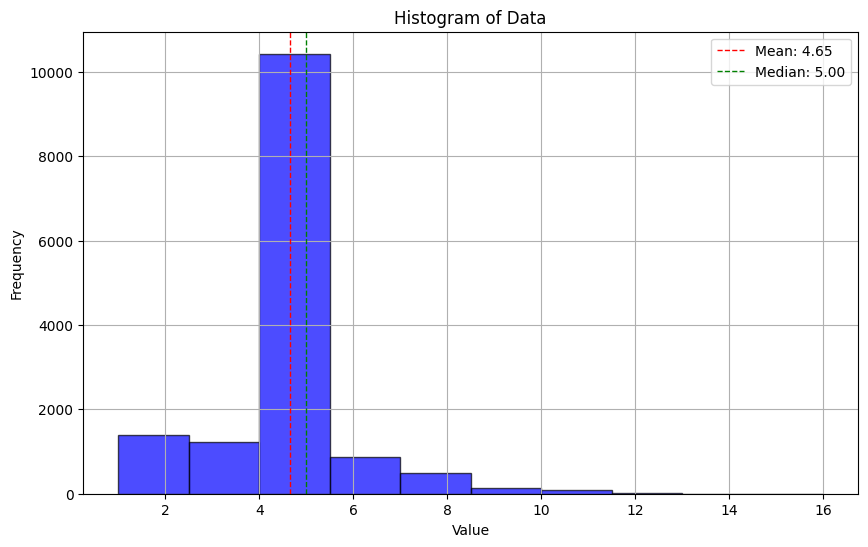

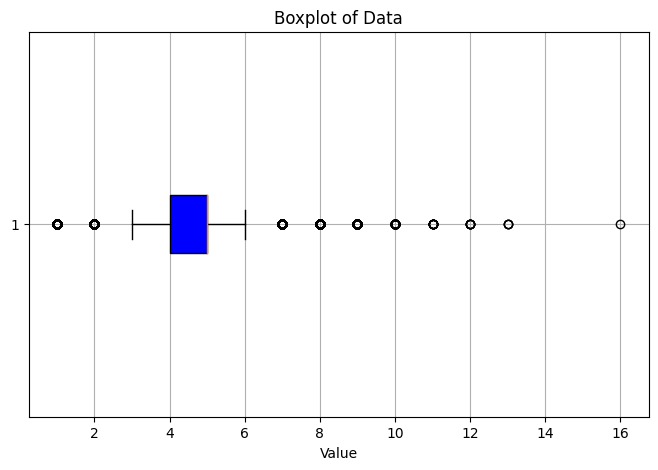

In [124]:
import numpy as np
import matplotlib.pyplot as plt

# Example data list
data = len_count_nonzero

# Calculate basic statistics
mean = np.mean(data)
median = np.median(data)
std_dev = np.std(data)
variance = np.var(data)
minimum = np.min(data)
maximum = np.max(data)
percentiles = np.percentile(data, [25, 50, 75])  # 25th, 50th (median), and 75th percentiles

# Print the statistical analysis
print("Statistical Analysis:")
print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Standard Deviation: {std_dev}")
print(f"Variance: {variance}")
print(f"Minimum: {minimum}")
print(f"Maximum: {maximum}")
print(f"25th, 50th, 75th Percentiles: {percentiles}")

# Visualization: Histogram
plt.figure(figsize=(10, 6))
plt.hist(data, bins=10, color='blue', alpha=0.7, edgecolor='black')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label=f"Mean: {mean:.2f}")
plt.axvline(median, color='green', linestyle='dashed', linewidth=1, label=f"Median: {median:.2f}")
plt.title("Histogram of Data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# Visualization: Boxplot
plt.figure(figsize=(8, 5))
plt.boxplot(data, vert=False, patch_artist=True, boxprops=dict(facecolor='blue', color='black'))
plt.title("Boxplot of Data")
plt.xlabel("Value")
plt.grid(True)
plt.show()
